### Fitting model description
那过程就大概是这样
1. 先用 3 个voigt (elastic + phonons) 1 个 convoluted DHO (CDF) 拟合数据
2. 用拟合结果把 elastic 减掉
3. 用 simulation 把两个phonon减掉
4. 把最后的结果去拟合 CDF 

In [1]:
import sys 
sys.path.append('codes')
from scipy.optimize import curve_fit
import MyFunctions as mf
import matplotlib.pyplot as plt
import rixs_tools as rt
from scipy.signal import convolve
import numpy as np
from rixs_experiment import RIXS_EXP 
System = rt.create_system()
exp = RIXS_EXP()


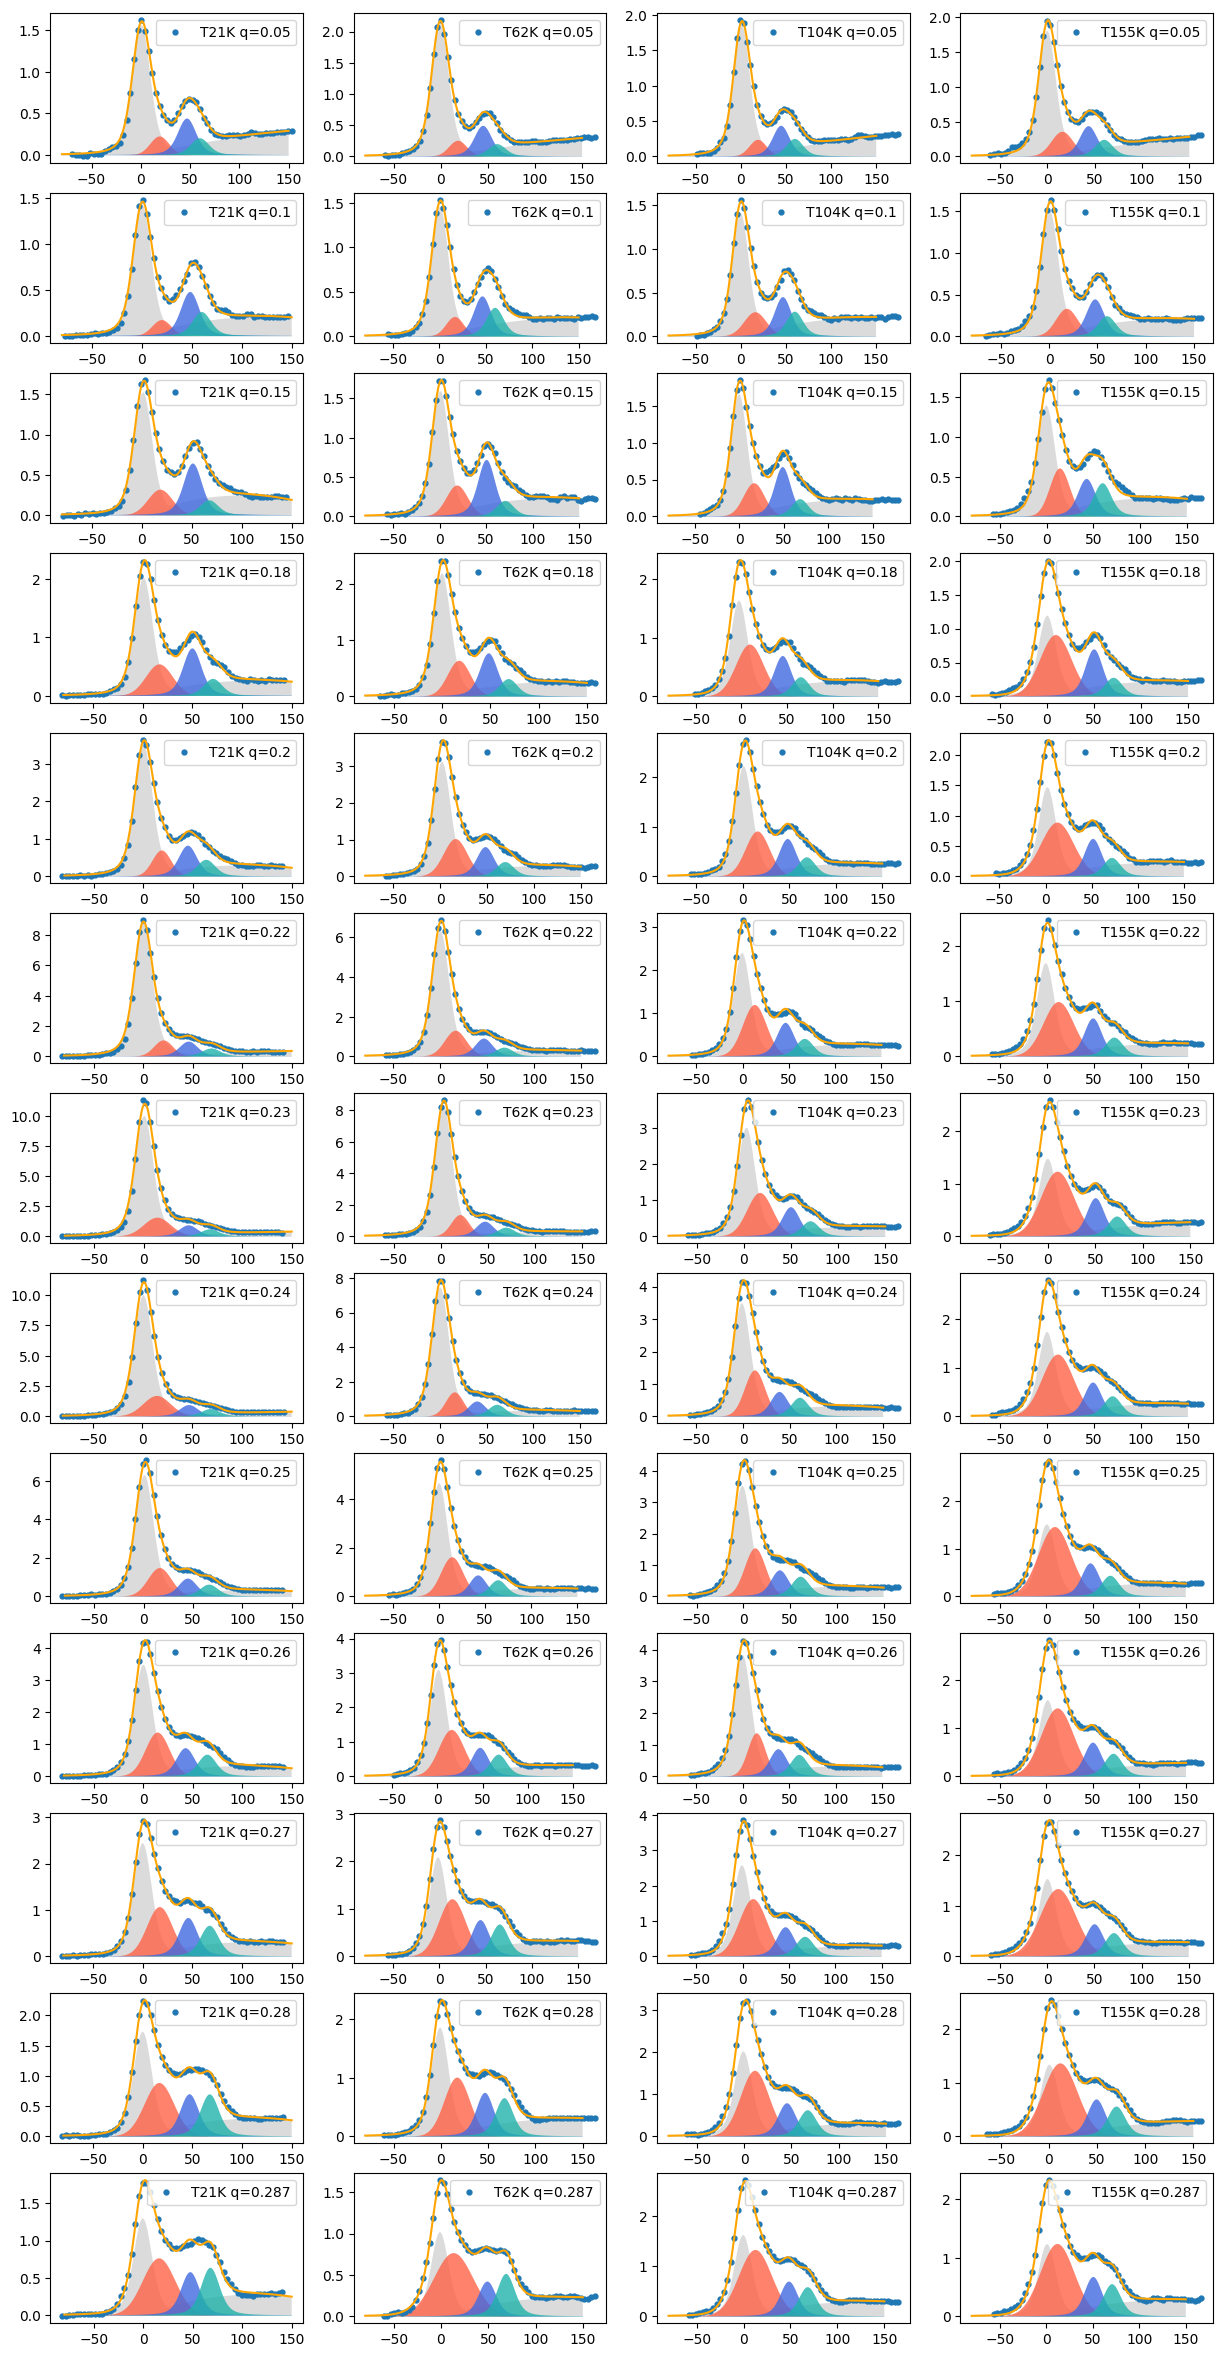

In [2]:
# basic fitting
# firts step: we fit the data with free parameters for CDF (gaussian)


fL = exp._fL_preset
fG = exp._fG_preset



def function_to_fit(x, *parameters):
    res = exp._resolution
    global T
    y1 = mf.fun_voigt(x, *parameters[0:4])  # elastic
    # y2 = fun_DHO_bose(x,*parameters[4:7]) # CDF
    # y2 = mf.fun_DHO(x,*parameters[4:7]) # CDF
    # y2 = mf.convoluted_fun(x, res, mf.fun_DHO, *parameters[4:7]) # CDF
    # y2 = mf.fun_lorentzian(x, *parameters[4:7]) # CDF
    y2 = mf.fun_gaussian(x, *parameters[4:7]) # CDF
    y3 = mf.fun_voigt(x, *parameters[7:9], *parameters[2:4]) # 1st phonon 
    y4 = mf.fun_voigt(x, *parameters[9:11], *parameters[2:4]) # 2nd phonon
    y5 = mf.fun_voigt(x, *parameters[11:13], *parameters[2:4]) # 3rd phonon
    y6 = mf.fun_quadratic(x, *parameters[13:15])# background
    return y1+y2+y3+y4+y5+y6 



#temperature_chars = ['T104K']
temperature_chars = exp._temperature_list_string
res = exp._resolution
fig, axs = plt.subplots(13,4,figsize=(15,30))
for i,temperature_char in enumerate(temperature_chars):
    T = exp._temperature_list_meV[i]

    popt =      [0, 5, fG, fL,\
                10, 0.34, 23,\
                40, 0.17,\
                52, 0,\
                75, 0.1,\
                160, 0.2]
    for q_index in range(exp._q_size):
        ax = axs[q_index,i]

        # test the function
        x = np.linspace(-80,150,1000)

        f_epsilon = 0.1
        epsilon = 0.01
        parameters_guess = popt

        parameters_lower = [-10, 0, fG-f_epsilon, fL-f_epsilon,\
                            0, 0, res, \
                            20, 0,\
                            40, 0,\
                            60, 0,\
                            100, 0]
        parameters_upper = [10, 10, fG+f_epsilon, fL+f_epsilon,\
                            40, 2, 100,\
                            70, 3,\
                            70, epsilon,\
                            105, 3,\
                            500, 3]
        data_T = exp.Aligned_interesting_data[temperature_char]
        energy = data_T[:,2*q_index]
        intensity = data_T[:,2*q_index+1]
        sigma = np.ones(len(energy))
        sigma[(energy>-13)&(energy<30)] = 0.2
        popt, perr = exp.basic_fit(temperature_char, q_index, function_to_fit, parameters_guess, parameters_bound=(parameters_lower, parameters_upper),
                                   sigma = sigma)        
        exp.Fit_results[temperature_char]['optimized_parameters'][q_index] = popt
        exp.Fit_results[temperature_char]['errors'][q_index] = perr
        exp.Fit_results[temperature_char]['fitting_info'] = "voigt for background, lorentzian for CDF, voigt for 3 phonons, quadratic for background"
        exp.plot_data(temperature_char, q_index, ax = ax)
        exp.plot_fit_conponent(function_to_fit, popt, ax = ax, fill = False, label = 'fit', color = 'orange') # total fit
        exp.plot_fit_conponent(mf.fun_voigt, popt[0:4], ax = ax, fill = True, label = 'elastic', color = 'lightgrey') # elastic
        exp.plot_fit_conponent(mf.fun_quadratic, popt[13:15], ax = ax, fill = True, label = 'background', color = 'lightgrey') # background
        #exp.plot_fit_conponent(mf.fun_DHO, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato') # CDF
        # exp.plot_fit_conponent(mf.convoluted_fun, [res,mf.fun_DHO, *popt[4:7]], ax = ax, fill = True, label = 'CDF', color = 'tomato') # CDF
        #exp.plot_fit_conponent(mf.fun_lorentzian, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato')
        exp.plot_fit_conponent(mf.fun_gaussian, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato')
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[7:9],*popt[2:4]], ax = ax, fill = True, label = '1st phonon', color = 'royalblue') # 1st phonon
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[9:11],*popt[2:4]], ax = ax, fill = True, label = '2nd phonon', color = 'lightgreen') # 2nd phonon
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[11:13],*popt[2:4]], ax = ax, fill = True, label = '3rd phonon', color = 'lightseagreen') # 3rd phonon
        #ax.set_ylim(-0.1,2)
        exp.Subtracted_realigned_interesting_data[temperature_char][:,2*q_index+1] = intensity - mf.fun_voigt(energy, *popt[0:4]) - mf.fun_quadratic(energy, *popt[13:15])
        exp.Subtracted_realigned_interesting_data[temperature_char][:,2*q_index] = energy - popt[0]
        



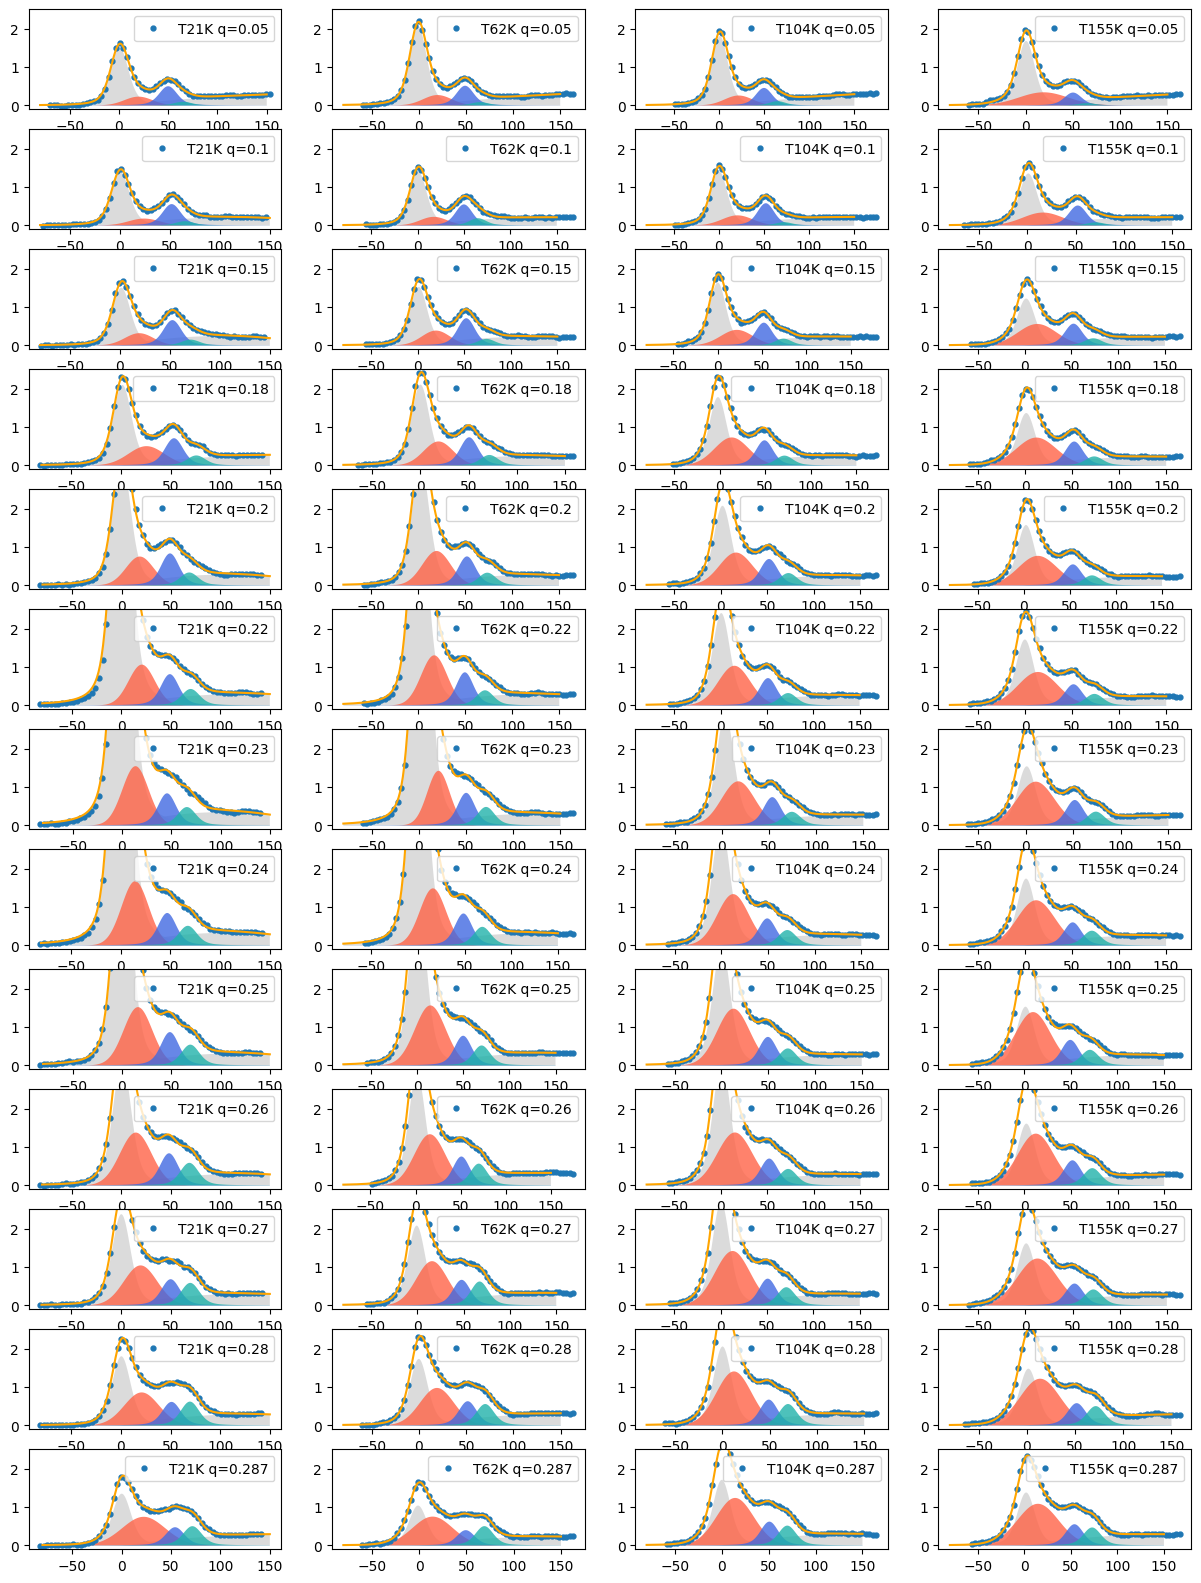

In [3]:
## second step, we fix the CDF position and fit the data with free parameters for the 
fig, axs = plt.subplots(13,4,figsize=(15,20))
for i,temperature_char in enumerate(temperature_chars):
    T = exp._temperature_list_meV[i]
    CDF_position = exp.Fit_results[temperature_char]['optimized_parameters'][0][4]
    popt =      [0, 5, fG, fL,\
                CDF_position, 1, 20,\
                40, 0.5,\
                52, 0,\
                75, 0.1,\
                160, 0.2]
    for j,q_index in enumerate(range(exp._q_size)):
        ax = axs[j,i]
        CDF_position = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][4]
        # test the function
        x = np.linspace(-80,150,1000)

        f_epsilon = 0.2
        epsilon = 0.0001
        parameters_guess = popt
        popt[4] = CDF_position if (j== 6 or j==7 or j==8 or j==9) else popt[4]
        CDF_lower = CDF_position if (j== 6 or j==7 or j==8 or j==9) else 0
        CDF_upper = CDF_position+epsilon if (j== 6 or j==7 or j==8 or j==9) else 40
        
        


        parameters_lower = [-10, 0, fG-f_epsilon, fL-f_epsilon,\
                            CDF_lower, 0, 0, \
                            20, 0,\
                            40, 0,\
                            65, 0,\
                            100, 0]
        parameters_upper = [10, 10, fG+f_epsilon, fL+f_epsilon,\
                            CDF_upper, 10, 100,\
                            70, 10,\
                            70, 0+epsilon,\
                            105, 10,\
                            500, 10]
        data_T = exp.Aligned_interesting_data[temperature_char]
        energy = data_T[:,2*q_index]
        intensity = data_T[:,2*q_index+1]
        sigma = np.ones(len(energy))
        #sigma[(energy>-16)&(energy<30)] = 0.7
        popt, perr = exp.basic_fit(temperature_char, q_index, function_to_fit, parameters_guess, parameters_bound=(parameters_lower, parameters_upper),sigma = sigma)        
        exp.Fit_results[temperature_char]['optimized_parameters'][q_index] = popt
        exp.Fit_results[temperature_char]['errors'][q_index] = perr
        exp.Fit_results[temperature_char]['fitting_info'] = "voigt for background, lorentzian for CDF, voigt for 3 phonons, quadratic for background"
        exp.plot_data(temperature_char, q_index, ax = ax)
        exp.plot_fit_conponent(function_to_fit, popt, ax = ax, fill = False, label = 'fit', color = 'orange') # total fit
        exp.plot_fit_conponent(mf.fun_voigt, popt[0:4], ax = ax, fill = True, label = 'elastic', color = 'lightgrey') # elastic
        exp.plot_fit_conponent(mf.fun_quadratic, popt[13:15], ax = ax, fill = True, label = 'background', color = 'lightgrey') # background
        # exp.plot_fit_conponent(mf.fun_DHO, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato') # CDF
        # exp.plot_fit_conponent(mf.convoluted_fun, [res,mf.fun_DHO, *popt[4:7]], ax = ax, fill = True, label = 'CDF', color = 'tomato') # CDF
        # exp.plot_fit_conponent(mf.fun_lorentzian, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato')
        exp.plot_fit_conponent(mf.fun_gaussian, popt[4:7], ax = ax, fill = True, label = 'CDF', color = 'tomato')
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[7:9],*popt[2:4]], ax = ax, fill = True, label = '1st phonon', color = 'royalblue') # 1st phonon
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[9:11],*popt[2:4]], ax = ax, fill = True, label = '2nd phonon', color = 'lightgreen') # 2nd phonon
        exp.plot_fit_conponent(mf.fun_voigt, [*popt[11:13],*popt[2:4]], ax = ax, fill = True, label = '3rd phonon', color = 'lightseagreen') # 3rd phonon
        ax.set_ylim(-0.1,2.5)
        # set legend to northeast

        # fill the sutracted_realigned_data in exp object by subtracting the elastic and the background
        exp.Subtracted_realigned_interesting_data[temperature_char][:,2*q_index+1] = intensity - mf.fun_voigt(energy, *popt[0:4]) - mf.fun_quadratic(energy, *popt[13:15])
        exp.Subtracted_realigned_interesting_data[temperature_char][:,2*q_index] = energy - popt[0]

        
# save figure
#fig.tight_layout()
#fig.savefig('dho_fitting_results.jpg',dpi=100)




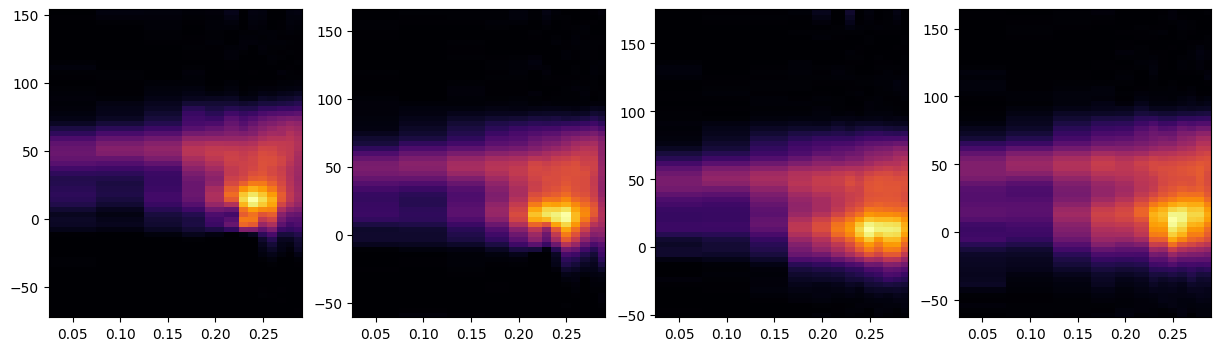

In [4]:
# third step: interpolate the data with a standard grid
from scipy.interpolate import interp1d

fig,axes = plt.subplots(1,4,figsize=(15,4))


for j,temperature_char in enumerate(exp.temperature_list_string):
    energies = exp.Subtracted_realigned_interesting_data[temperature_char][:,0::2]
    intensities = exp.Subtracted_realigned_interesting_data[temperature_char][:,1::2]
    y_interpolate = exp.Subtracted_realigned_interesting_data[temperature_char][:,0]
    z_interpolate = np.zeros((len(y_interpolate),exp._q_size))
    for i in range(exp._q_size):
        f = interp1d(energies[:,i], intensities[:,i], kind='linear', fill_value='extrapolate')
        z_interpolate[:,i] = f(y_interpolate)
        exp.Interpolated_subtracted_realigned_interesting_data[temperature_char][:,2*i] = y_interpolate
        exp.Interpolated_subtracted_realigned_interesting_data[temperature_char][:,2*i+1] = z_interpolate[:,i]
    X,Y = np.meshgrid(exp.q_list,y_interpolate)
    z_interpolate[z_interpolate<0] = 0
    axes[j].pcolor(X,Y,z_interpolate,cmap='inferno')


In [5]:
# define a convolution function for the simulation

from scipy.signal import convolve
def convolve_simulation(x,y,res):
    x_left = min(x)
    x_right = max(x)
    x_left_shifted = x_left - (x_right + x_left)/2
    x_right_shifted = x_right - (x_right + x_left)/2
    x_gaussian = np.linspace(x_left_shifted, x_right_shifted, len(x))
    gaussian_curve = mf.fun_gaussian(x_gaussian, 0, 1, res)
    
    # Calculate fun_s for a range of x values
    max_value = max(y)
    # Convolute fun_s with the Gaussian
    # Assume x is a numpy array for simplicity; adjust as necessary for your case
    convoluted_values = convolve(y, gaussian_curve, mode='same')
    max_convoluted_value = max(convoluted_values)
    return convoluted_values/max_convoluted_value*max_value


max of a1g = 6.623407 and max of b1g = 0.918223. ratio = 7.213288057476234


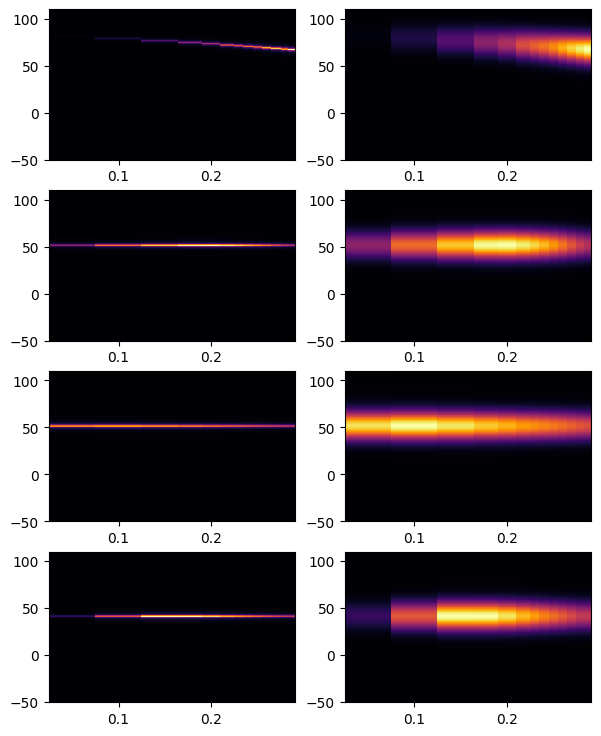

In [6]:
# forth step: load the simulations

resolution = 23
X_simulation = np.loadtxt('./simulation_data/X.txt')/System.paras.knorm
Y_simulation = np.loadtxt('./simulation_data/Y.txt')
Z_simulation_apical = np.loadtxt('./simulation_data/Z_ap.txt')
Z_simulation_breathing = np.loadtxt('./simulation_data/Z_br.txt')
Z_simulation_a1g = np.loadtxt('./simulation_data/Z_a1g.txt')
Z_simulation_b1g = np.loadtxt('./simulation_data/Z_b1g.txt')  # Add this line
print(f"max of a1g = {np.max(Z_simulation_a1g)} and max of b1g = {np.max(Z_simulation_b1g)}. ratio = {np.max(Z_simulation_a1g)/np.max(Z_simulation_b1g)}") 
Z_simulation_apical[Z_simulation_apical<0] = 0
Z_simulation_breathing[Z_simulation_breathing<0] = 0
Z_simulation_a1g[Z_simulation_a1g<0] = 0
Z_simulation_b1g[Z_simulation_b1g<0] = 0  # Add this line
fig,ax = plt.subplots(4,2,figsize=(7,9))  # Modify the subplot size

ax[0,0].pcolor(X_simulation,Y_simulation,Z_simulation_breathing,cmap='inferno')
Z_simulation_breathing_conv = np.zeros(np.shape(Z_simulation_breathing))
for q_index,q in enumerate(exp.q_list):
    y = Y_simulation[:,q_index]
    z = Z_simulation_breathing[:,q_index]
    z_conv = convolve_simulation(y,z,resolution)
    Z_simulation_breathing_conv[:,q_index] = z_conv/20
ax[0,1].pcolor(X_simulation,Y_simulation,Z_simulation_breathing_conv,cmap='inferno')
Z_simulation_breathing_conv = Z_simulation_breathing_conv/np.max(Z_simulation_breathing_conv)

ax[1,0].pcolor(X_simulation,Y_simulation,Z_simulation_apical,cmap='inferno')
Z_simulation_apical_conv = np.zeros(np.shape(Z_simulation_apical))
for q_index,q in enumerate(exp.q_list):
    y = Y_simulation[:,q_index]
    z = Z_simulation_apical[:,q_index]
    z_conv = convolve_simulation(y,z,resolution)
    Z_simulation_apical_conv[:,q_index] = z_conv/20
ax[1,1].pcolor(X_simulation,Y_simulation,Z_simulation_apical_conv,cmap='inferno')
Z_simulation_apical_conv = Z_simulation_apical_conv/np.max(Z_simulation_apical_conv)

ax[2,0].pcolor(X_simulation,Y_simulation,Z_simulation_a1g,cmap='inferno')
Z_simulation_a1g_conv = np.zeros(np.shape(Z_simulation_a1g))
for q_index,q in enumerate(exp.q_list):
    y = Y_simulation[:,q_index]
    z = Z_simulation_a1g[:,q_index]
    z_conv = convolve_simulation(y,z,resolution)
    Z_simulation_a1g_conv[:,q_index] = z_conv/20
ax[2,1].pcolor(X_simulation,Y_simulation,Z_simulation_a1g_conv,cmap='inferno')
Z_simulation_a1g_conv = Z_simulation_a1g_conv/np.max(Z_simulation_a1g_conv)

ax[3,0].pcolor(X_simulation,Y_simulation,Z_simulation_b1g,cmap='inferno')
Z_simulation_b1g_conv = np.zeros(np.shape(Z_simulation_b1g))
for q_index,q in enumerate(exp.q_list):
    y = Y_simulation[:,q_index]
    z = Z_simulation_b1g[:,q_index]
    z_conv = convolve_simulation(y,z,resolution)
    Z_simulation_b1g_conv[:,q_index] = z_conv/20
ax[3,1].pcolor(X_simulation,Y_simulation,Z_simulation_b1g_conv,cmap='inferno')
Z_simulation_b1g_conv = Z_simulation_b1g_conv/np.max(Z_simulation_b1g_conv)  # Add this line
plt.show()  # Add this line to display the plots


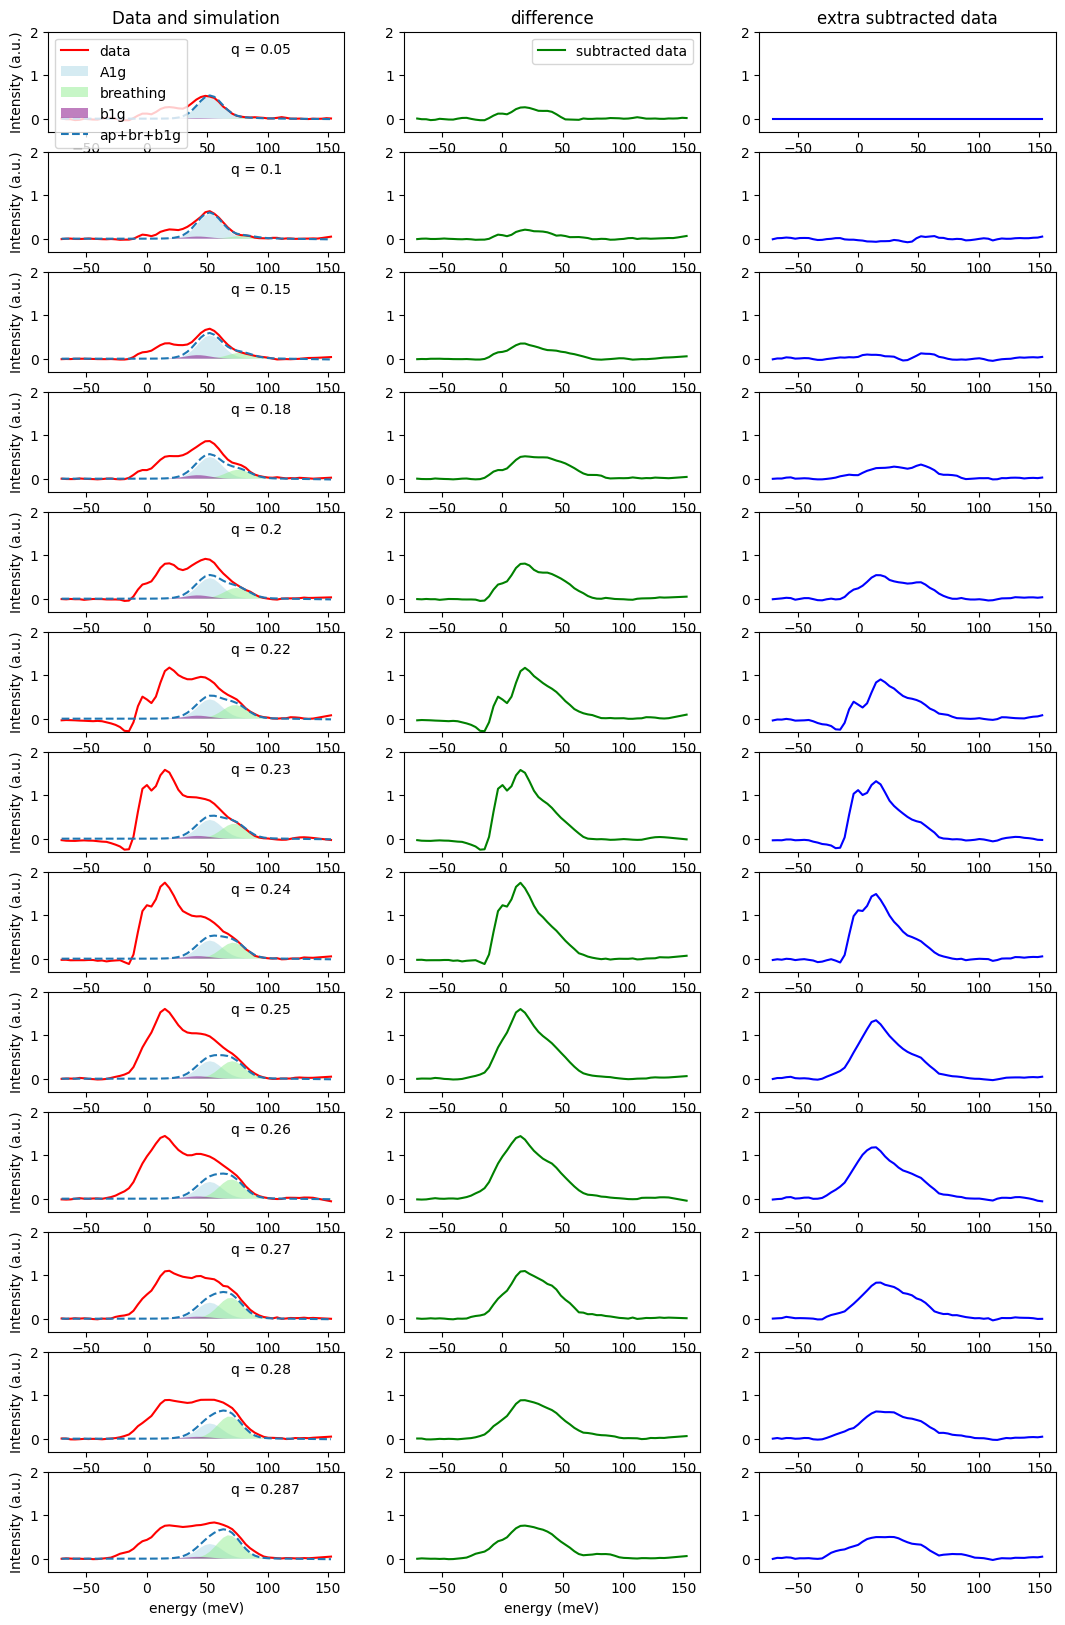

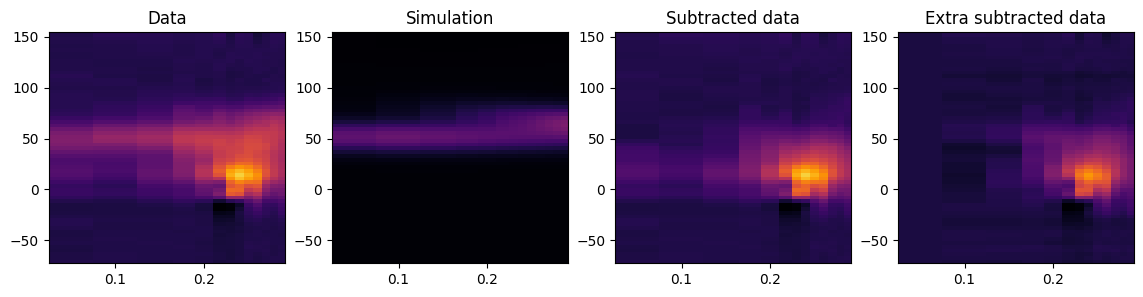

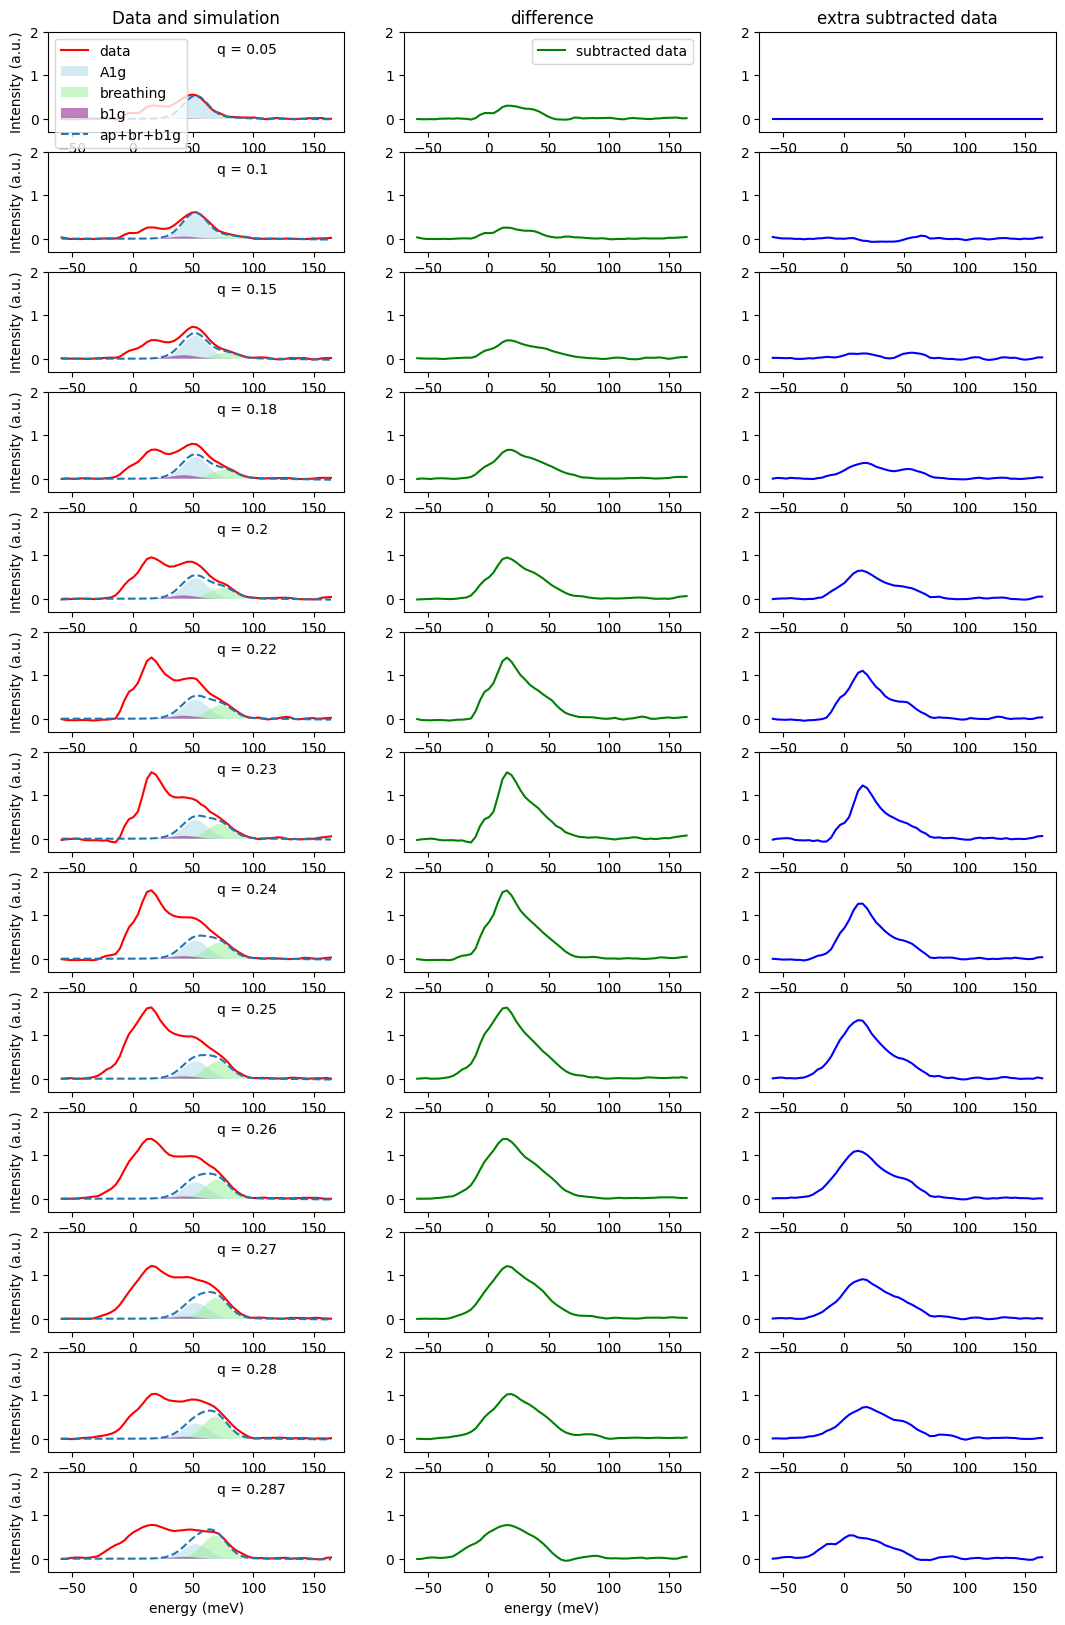

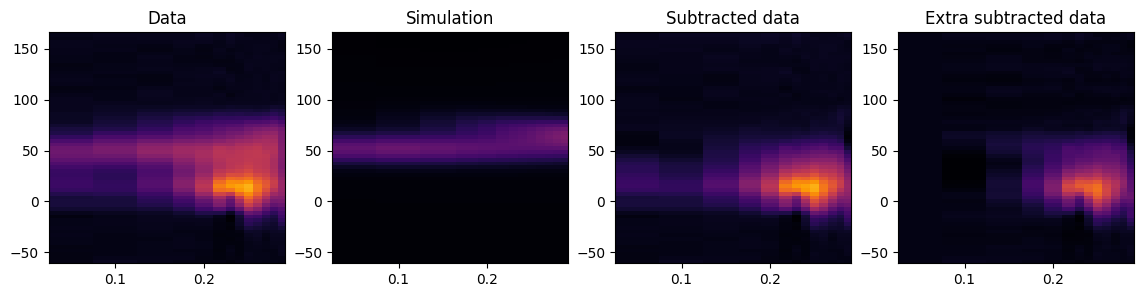

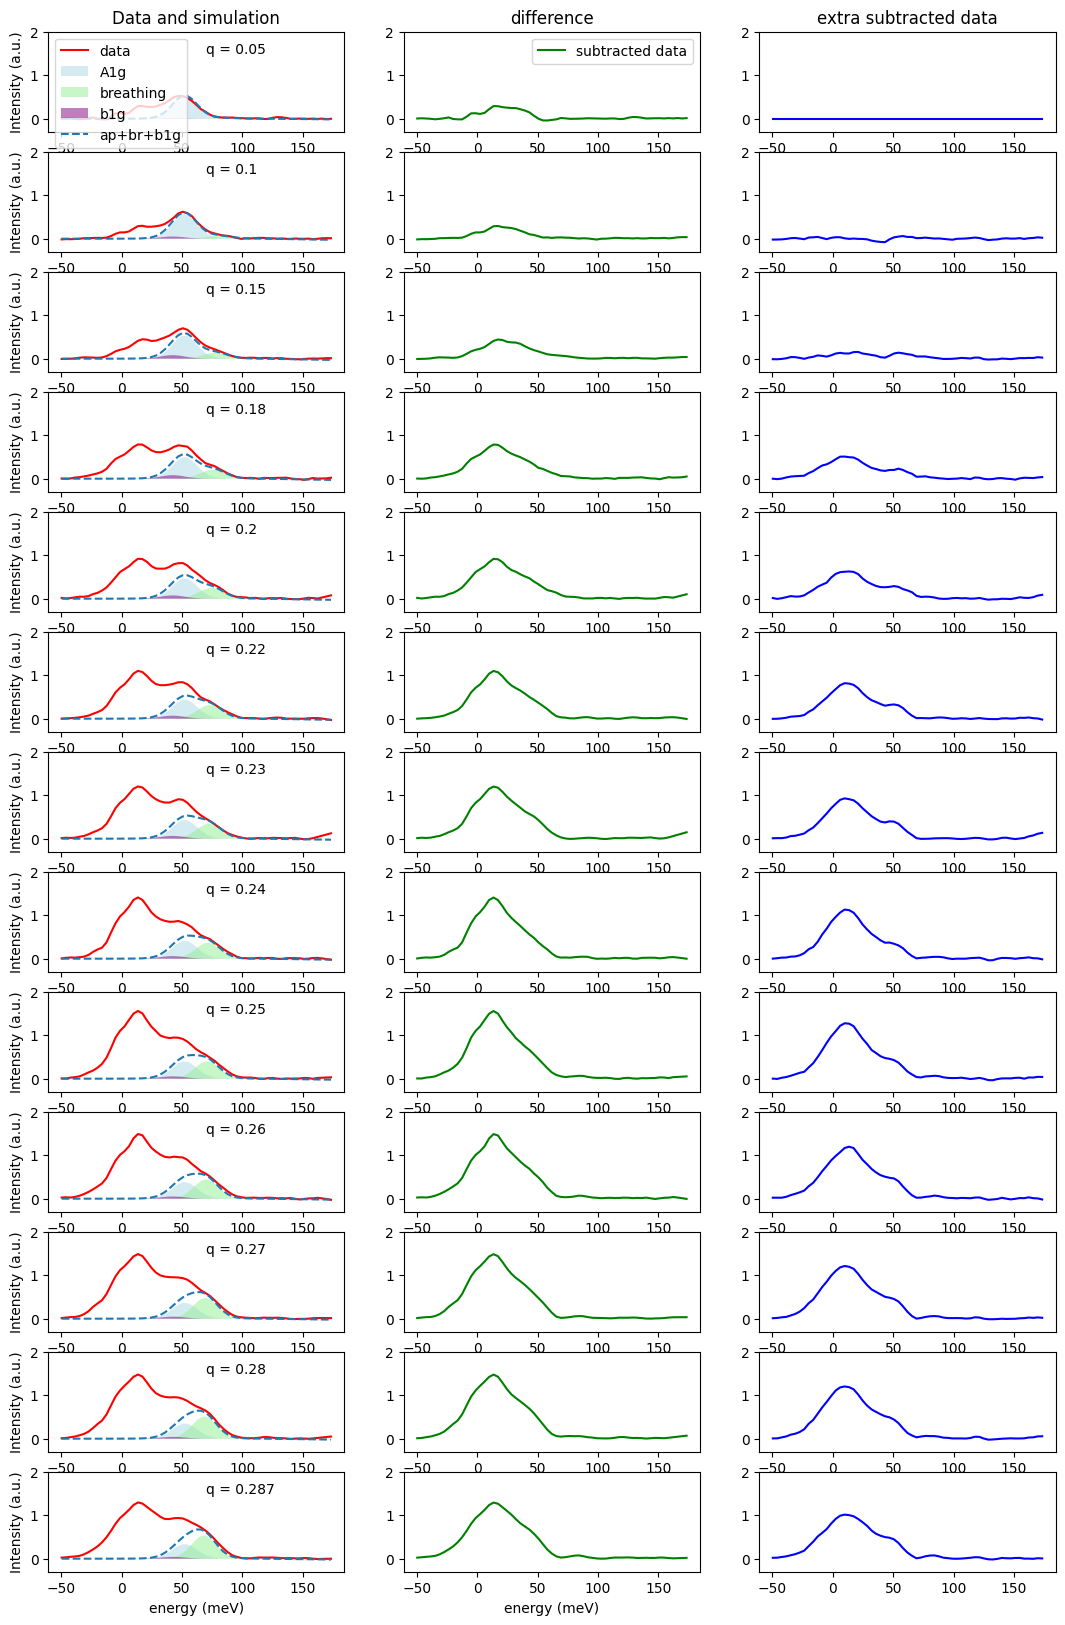

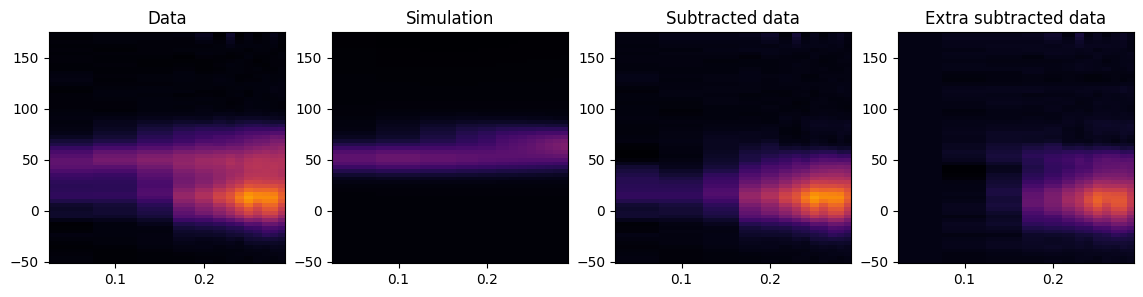

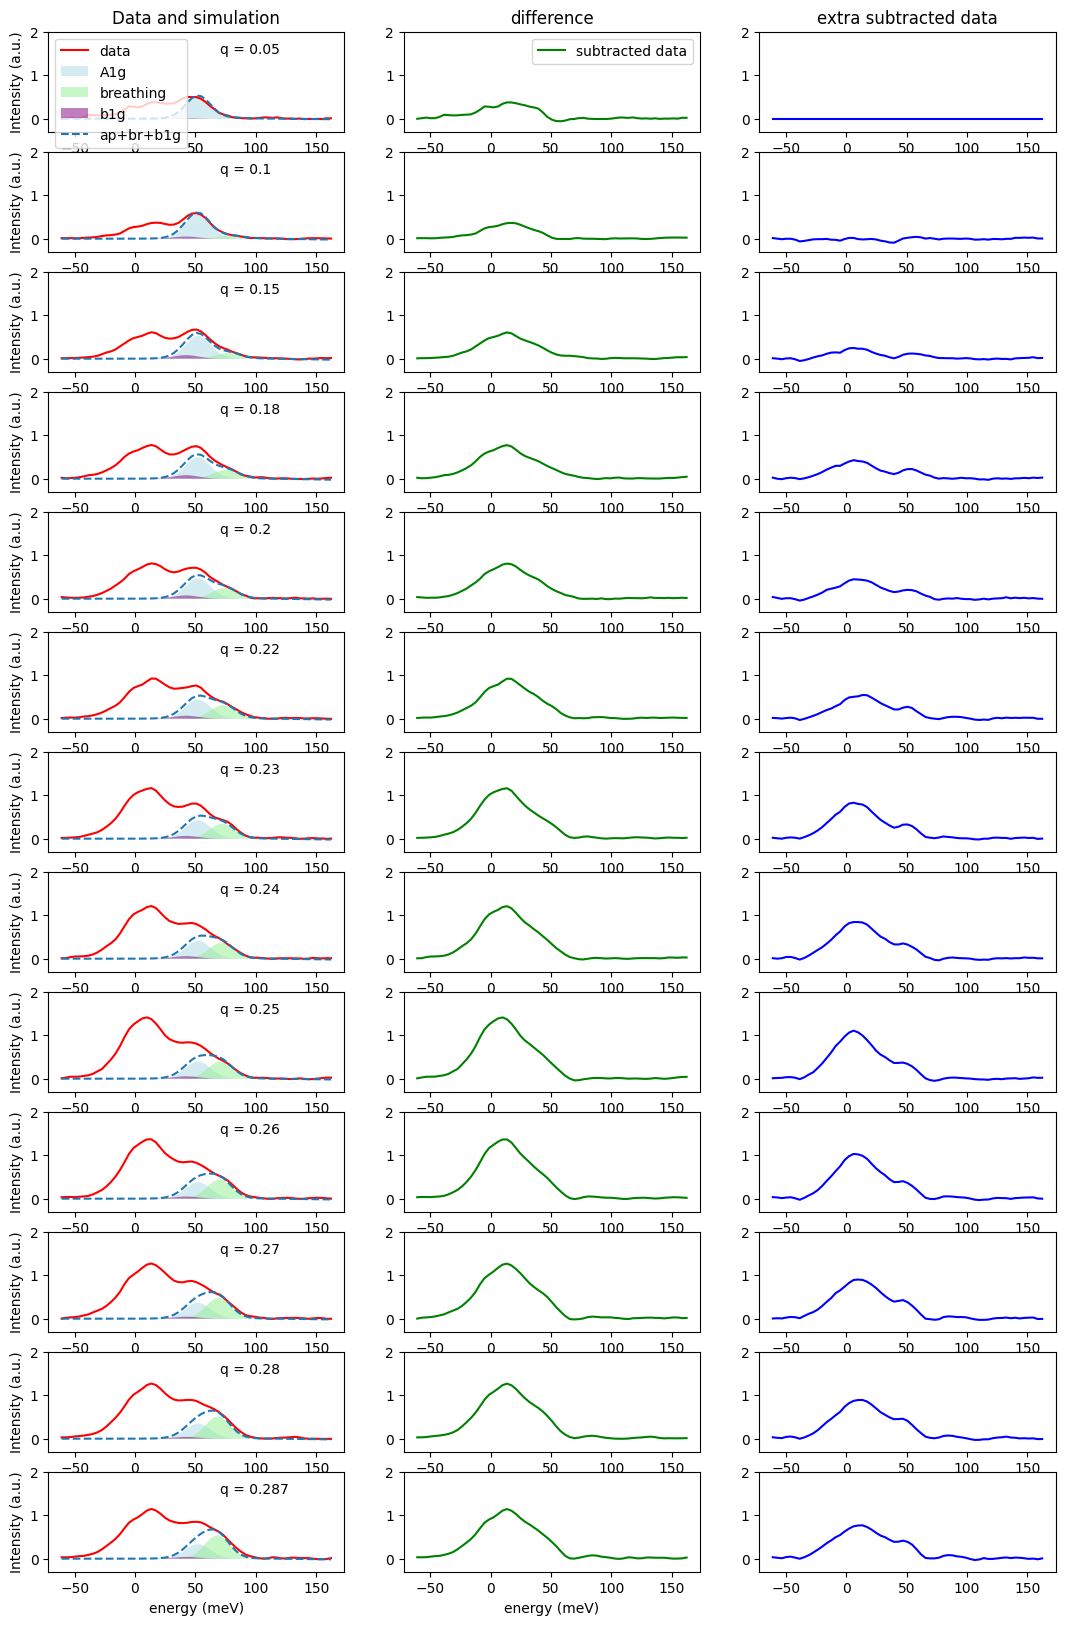

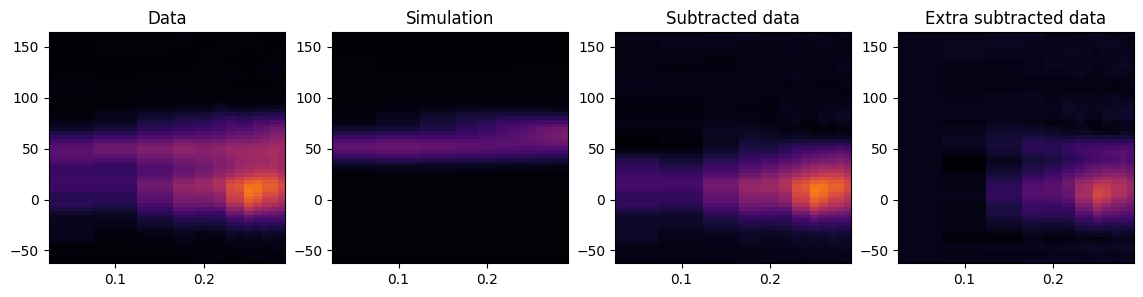

In [15]:
# Fifth step: subtract the simulation from the data
# convluted CDF + a1g + b1g + breathing
# the extract subtracted data = subtracted data - first-column of the data

from scipy.interpolate import interp1d

for temperature_char in exp._temperature_list_string:
    data =exp.Interpolated_subtracted_realigned_interesting_data[temperature_char]
    data_shape = np.shape(data)
    num_rows_data = data_shape[0]
    num_cols_data = int(data_shape[1]/2)
    x_data = np.array([0.05, 0.1, 0.15, 0.18, 0.2, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.287])
    i =  5
    y_data = data[:, 2*i]
    z_data = data[:, 2*i+1]
    y_standard = y_data

    simulation_shape = np.shape(Z_simulation_apical)
    num_rows_simulation = simulation_shape[0]
    num_cols_simulation = int(simulation_shape[1])

    # create standard-sized arrays
    Z_data_standard = np.zeros([len(y_standard), num_cols_data])
    Z_simulation_apical_standard = np.zeros([len(y_standard), num_cols_data])
    Z_simulation_breathing_standard = np.zeros([len(y_standard), num_cols_data])
    Z_simulation_a1g_standard = np.zeros([len(y_standard), num_cols_data])
    Z_simulation_b1g_standard = np.zeros([len(y_standard), num_cols_data])  

    multiplication_factor_apical = 0.75
    multiplication_factor_breathing = 0.54
    multiplication_factor_a1g = 0.57
    multiplication_factor_b1g = 0.57/7
    ap = Z_simulation_apical_conv*multiplication_factor_apical
    br = Z_simulation_breathing_conv*multiplication_factor_breathing
    a1g = Z_simulation_a1g_conv*multiplication_factor_a1g
    b1g = Z_simulation_b1g_conv*multiplication_factor_b1g
    
    Z_subtracted = np.zeros([len(y_standard), num_cols_data])
    Z_extra_subtracted = np.zeros([len(y_standard), num_cols_data])


    fig, axes = plt.subplots(13,3,figsize=(13,20))
    for i in range(num_cols_data):
        y = data[:, 2*i]
        z = data[:, 2*i+1]
        # interpolate Z_simulation with interp1d     
        f_a1g = interp1d(Y_simulation[:,i], a1g[:,i], kind='linear', fill_value='extrapolate')
        f_br = interp1d(Y_simulation[:,i], br[:,i], kind='linear', fill_value='extrapolate')
        f_b1g = interp1d(Y_simulation[:,i], b1g[:,i], kind='linear', fill_value='extrapolate')
        
        a1g_interp = f_a1g(y_standard)
        br_interp = f_br(y_standard)
        b1g_interp = f_b1g(y_standard)
        axes[i][0].plot(y_standard, z, 'r', label='data')
        # plot interpolated simulation will transparent filled curve
        axes[i][0].fill_between(y_standard, a1g_interp, 0, color='lightblue', alpha=0.5, edgecolor='none', label='A1g')
        axes[i][0].fill_between(y_standard, br_interp, 0, color='lightgreen', alpha=0.5, edgecolor='none', label='breathing')
        axes[i][0].fill_between(y_standard, b1g_interp, 0, color='purple', alpha=0.5, edgecolor='none', label='b1g')
        axes[i][0].plot(y_standard, br_interp+a1g_interp+b1g_interp, '--', label='ap+br+b1g')
        # legend
        axes[i][1].plot(y_standard,z-a1g_interp-br_interp, 'g', label='subtracted data')
        if i==0:
            z_background = z - a1g_interp - br_interp - b1g_interp
        axes[i][2].plot(y_standard,z-a1g_interp-br_interp - b1g_interp - z_background, 'b', label='extra subtracted data')
        axes[i,2].set_ylim([-0.3, 2])
        Z_data_standard[:, i] = z
        Z_simulation_a1g_standard[:, i] = a1g_interp
        Z_simulation_breathing_standard[:, i] = br_interp
        Z_subtracted[:, i] = z - a1g_interp - br_interp - b1g_interp
        Z_extra_subtracted[:, i] = z-a1g_interp-br_interp - b1g_interp - z_background
        # y range from -0.1 to 1.5
        axes[i][0].set_ylim([-0.3, 2])
        axes[i][1].set_ylim([-0.3, 2])
        # add corresonding x_data to the top right corner
        axes[i][0].text(70, 1.5, 'q = '+str(x_data[i]), fontsize=10)

        # titles and y labels
        if i == 0:
            axes[i][0].set_title('Data and simulation')
            axes[i][1].set_title('difference')
            axes[i][2].set_title('extra subtracted data')
            # legend
            axes[i][0].legend(loc='upper left')
            axes[i][1].legend(loc='upper right')
        axes[i][0].set_ylabel('Intensity (a.u.)')
        if i == num_cols_data-1:
            axes[i][0].set_xlabel('energy (meV)')
            axes[i][1].set_xlabel('energy (meV)')

    fig, ax = plt.subplots(1,4,figsize=(14,3))
    ax[0].pcolor(x_data,y_standard,Z_data_standard,cmap='inferno',vmax = 2)
    ax[0].set_title('Data')
    ax[1].pcolor(x_data,y_data, Z_simulation_a1g_standard+Z_simulation_breathing_standard+Z_simulation_b1g_standard, cmap='inferno',vmax = 2)
    ax[1].set_title('Simulation')
    ax[2].pcolor(x_data,y_standard,Z_subtracted,cmap='inferno',vmax = 2)
    ax[2].set_title('Subtracted data')
    ax[3].pcolor(x_data,y_standard,Z_extra_subtracted,cmap='inferno',vmax = 2)
    ax[3].set_title('Extra subtracted data')
    # save figure
    # plt.savefig('lesco_method4_data_subracted_by_simulation.jpg', dpi=100, bbox_inches='tight')
    exp.Pure_CDF_data[temperature_char] = dict(X=x_data, Y=y_standard, Z_subtracted=Z_subtracted, Z_extra_subtracted=Z_extra_subtracted)
    exp.Phonon_simulation[temperature_char] =dict(X=x_data, Y=y_standard, Z_a1g=Z_simulation_a1g_standard, Z_br=Z_simulation_breathing_standard, Z_b1g=Z_simulation_b1g_standard)




1.8102
5.3444
8.9648
13.361


(-3.0, 20.0)

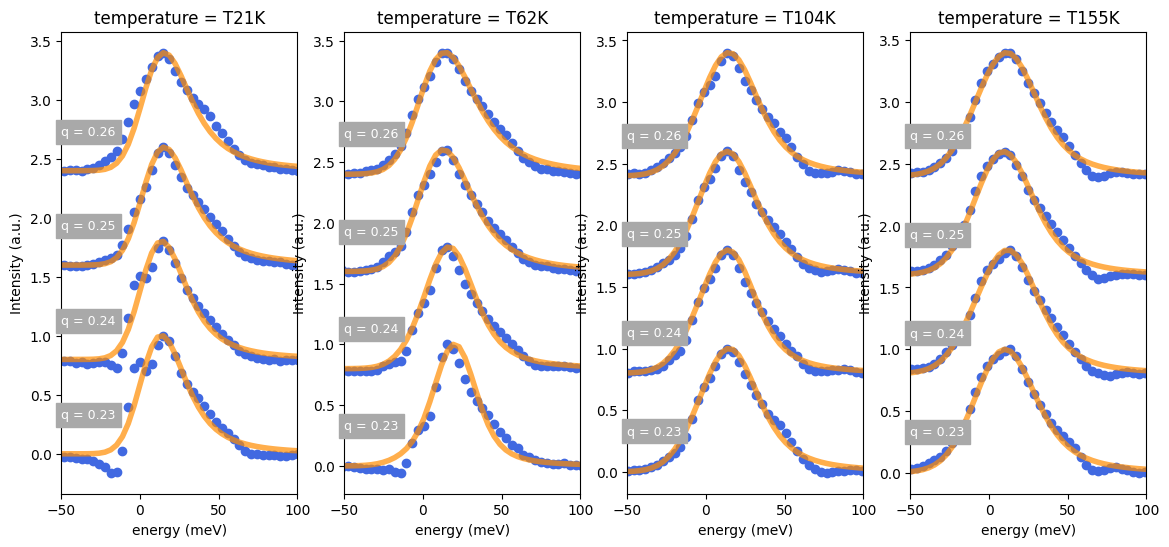

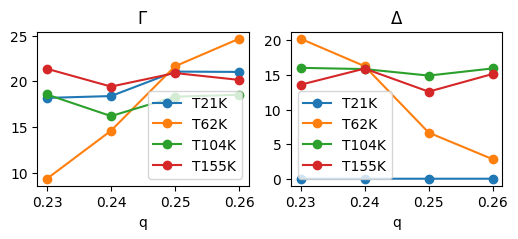

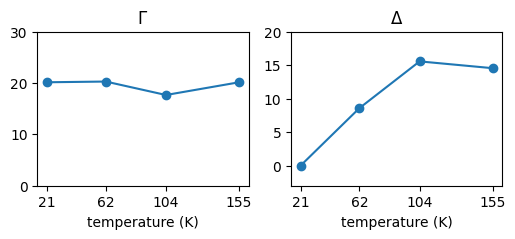

In [16]:
# Sixth step version 1: fit Z_subtracted with mf.S function convoluted with a gaussian over 4 momenta
def fun_chi(x,A,Gamma,Delta):
        normalization_factor = 1/2 * 1/np.sqrt(Delta**2)
        chi = 1/(Delta**2 - (x + 1j*(Gamma))**2)
        return np.imag(chi * normalization_factor)*A

def fun_S(x,A,Gamma,Delta,T):
    return 2/(1-np.exp(-x/T))*fun_chi(x,A,Gamma,Delta)

def fun_S_convoluted(x,Gamma,Delta,T):
    x_left = min(x)
    x_right = max(x)
    x_left_shifted = x_left - (x_right + x_left)/2
    x_right_shifted = x_right - (x_right + x_left)/2
    x_gaussian = np.linspace(x_left_shifted,x_right_shifted,len(x))
    res = exp._resolution
    y = fun_S(x,1,Gamma,Delta,T)
    y_conv = convolve(y, mf.fun_gaussian(x_gaussian,0,1,res), mode='same')
    return y_conv/max(y_conv)




Gamma_list = dict(T21K = np.zeros(4), T62K = np.zeros(4), T104K = np.zeros(4), T155K = np.zeros(4))
Delta_list = dict(T21K = np.zeros(4), T62K = np.zeros(4), T104K = np.zeros(4), T155K = np.zeros(4))


fig,ax = plt.subplots(1,4,figsize=(14,6))
temp_index= 1
for temp_index,temperature_char in enumerate(exp._temperature_list_string):
    x_data = exp.Pure_CDF_data[temperature_char]['X']
    y_data = exp.Pure_CDF_data[temperature_char]['Y']
    Z_subtracted = exp.Pure_CDF_data[temperature_char]['Z_subtracted']
    temperature = exp._temperature_list_meV[temp_index]
    print(temperature)
    for i,q_index in enumerate([6,7,8,9]):
        q = exp.q_list[q_index]
        y = y_data
        z = Z_subtracted[:,q_index]
        z=z/np.max(z)
        p0 = [3,10,temperature]
        epsilon = 0.01
        bounds = ([0,0,temperature],[100,100,temperature+epsilon])
        sigma = np.ones(len(z))
        sigma[(y>5)&(y<35)] = 1
        popt, pcov = curve_fit(fun_S_convoluted, y, z, p0 = p0, bounds=bounds,sigma = sigma)
        Gamma_list[temperature_char][i] = popt[0]
        Delta_list[temperature_char][i] = popt[1]
        ax[temp_index].plot(y,z+i*0.8, 'o',label = 'data', color='royalblue')
        ax[temp_index].plot(y,fun_S_convoluted(y,*popt)+i*0.8, label = '$S(q,\omega)$', color='darkorange',linewidth=4,alpha=0.7)
        ax[temp_index].set_title(f"temperature = {temperature_char}")
        ax[temp_index].set_xlim(-50,100)
        ax[temp_index].set_xlabel('energy (meV)')
        ax[temp_index].set_ylabel('Intensity (a.u.)')
        # mark on each curve the q value, black background and white font
        ax[temp_index].text(-50, i*0.8+0.3, f'q = {q}', color='white', fontsize=9, backgroundcolor='darkgrey')

# plot the fitting results
for i,q_index in enumerate([6,7,8,9]):
    q = exp.q_list[q_index]
    y = y_data
    z = Z_subtracted[:,q_index]

# plot Gamma and Delta at diff temperatures. Same color for each temperature
fig,ax = plt.subplots(1,2,figsize=(6,2))
for i,temperature_char in enumerate(exp._temperature_list_string):
    ax[0].plot(exp.q_list[6:10],Gamma_list[temperature_char], 'o-', label = temperature_char)
    ax[1].plot(exp.q_list[6:10],Delta_list[temperature_char], 'o-', label = temperature_char)
ax[0].set_title('$\Gamma$')
ax[1].set_title('$\Delta$')
ax[0].set_xlabel('q')
ax[1].set_xlabel('q')
ax[0].legend()
ax[1].legend()
ax[0].set_xticks(exp.q_list[6:10])
ax[1].set_xticks(exp.q_list[6:10])

# average q_index = 7,8,9 and plot gamma/delta vs temperature
fig,ax = plt.subplots(1,2,figsize=(6,2))
Gamma_avg = np.zeros(4)
Delta_avg = np.zeros(4)
for i,temperature_char in enumerate(exp._temperature_list_string):
    Gamma_avg[i] = np.mean(Gamma_list[temperature_char][1:])
    Delta_avg[i] = np.mean(Delta_list[temperature_char][1:])
ax[0].plot(exp._temperature_list_K,Gamma_avg, 'o-')
ax[1].plot(exp._temperature_list_K,Delta_avg, 'o-')
ax[0].set_title('$\Gamma$')
ax[1].set_title('$\Delta$')
ax[0].set_xlabel('temperature (K)')
ax[1].set_xlabel('temperature (K)')
ax[0].set_xticks(exp._temperature_list_K)
ax[1].set_xticks(exp._temperature_list_K)
ax[0].set_ylim(0,30)
ax[1].set_ylim(-3,20)


1.8102
5.3444
8.9648
13.361


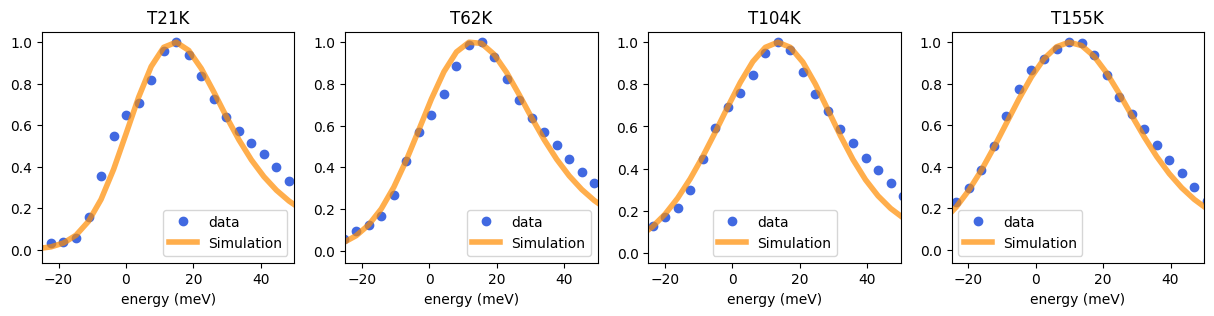

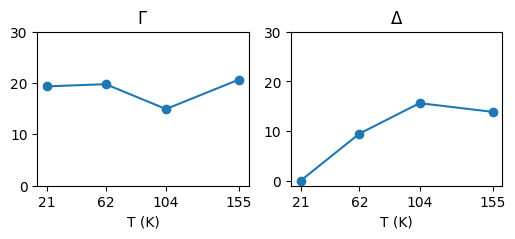

In [17]:
# Sixth step version 2: Summing up q=0.24/0.25/0.26 and fit Z_subtracted with mf.S function convoluted with a gaussian
def fun_chi(x,A,Gamma,Delta):
        normalization_factor = 1/2 * 1/np.sqrt(Delta**2)
        chi = 1/(Delta**2 - (x + 1j*(Gamma))**2)
        return np.imag(chi * normalization_factor)*A

def fun_S(x,A,Gamma,Delta,T):
    return 2/(1-np.exp(-x/T))*fun_chi(x,A,Gamma,Delta)

def fun_S_convoluted(x,Gamma,Delta,T):
    x_left = min(x)
    x_right = max(x)
    x_left_shifted = x_left - (x_right + x_left)/2
    x_right_shifted = x_right - (x_right + x_left)/2
    x_gaussian = np.linspace(x_left_shifted,x_right_shifted,len(x))
    res = exp._resolution
    y = fun_S(x,1,Gamma,Delta,T)
    y_conv = convolve(y, mf.fun_gaussian(x_gaussian,0,1,res), mode='same')
    return y_conv/max(y_conv)




Gamma_list = np.zeros(4)
Delta_list = np.zeros(4)
fig,ax = plt.subplots(1,4,figsize=(15,3))
temp_index= 1
for temp_index,temperature_char in enumerate(exp._temperature_list_string):
    x_data = exp.Pure_CDF_data[temperature_char]['X']
    y_data = exp.Pure_CDF_data[temperature_char]['Y']
    Z_subtracted = exp.Pure_CDF_data[temperature_char]['Z_subtracted']
    temperature = exp._temperature_list_meV[temp_index]
    print(temperature)

    y = y_data
    z = (np.mean(Z_subtracted[:,7:10],axis=1))
    z=z/np.max(z)
    p0 = [10,10,temperature]
    epsilon = 0.01
    bounds = ([0,0,temperature],[100,100,temperature+epsilon])
    sigma = np.ones(len(z))
    sigma[(y>5)&(y<30)] = 0.3
    popt, pcov = curve_fit(fun_S_convoluted, y, z, p0 = p0, bounds=bounds,sigma = sigma)
    Gamma_list[temp_index] = popt[0]
    Delta_list[temp_index] = popt[1]
    ax[temp_index].plot(y,z, 'o',label = 'data', color='royalblue')
    ax[temp_index].plot(y,fun_S_convoluted(y,*popt), label = 'Simulation', color='darkorange',linewidth=4,alpha=0.7)
    ax[temp_index].set_title(temperature_char)
    ax[temp_index].set_xlim(-25,50)
    ax[temp_index].set_xlabel('energy (meV)')
    #ax[temp_index].set_ylabel('Intensity (a.u.)')
    ax[temp_index].legend()
        # mark on each curve the q value, black background and white font

# plot the fitting results


# plot Gamma and Delta at diff temperatures. Same color for each temperature
fig,ax = plt.subplots(1,2,figsize=(6,2))
ax[0].plot(exp._temperature_list_K,Gamma_list, 'o-')
ax[1].plot(exp._temperature_list_K,Delta_list, 'o-')
ax[0].set_title('$\Gamma$')
ax[1].set_title('$\Delta$')
ax[0].set_xlabel('T (K)')
ax[1].set_xlabel('T (K)')
ax[0].set_ylim(0,30)
ax[1].set_ylim(-1,30)
ax[0].set_xticks(exp._temperature_list_K)
ax[1].set_xticks(exp._temperature_list_K)





In [18]:
# last step: save the exp object to a pkl file
import pickle

folder = 'processed_data/'
filename = 'processed_exp.pkl'

# Serialize the object to a file
with open(folder+filename, 'wb') as output_file:
    pickle.dump(exp, output_file)

# Later... Load the object back from the file
with open(folder+filename, 'rb') as input_file:
    loaded_object = pickle.load(input_file)



In [19]:
loaded_object.Pure_CDF_data.keys()

dict_keys(['T21K', 'T62K', 'T104K', 'T155K', 'info'])

(-30.0, 100.0)

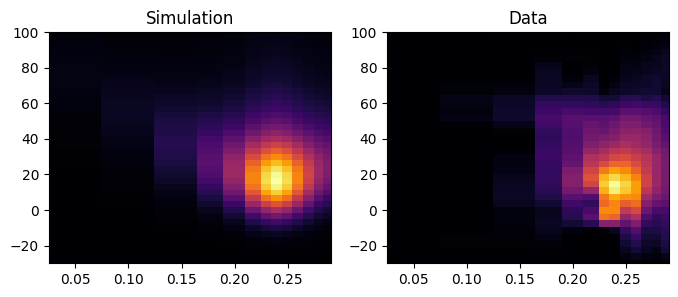

In [21]:
# fit Z_subtracted with mf.S function convoluted with a gaussian
def fun_chi(x,y,c,A,Gamma,Delta):
        q_cdf = 0.24
        #normalization_factor = 1/2 * 1/np.sqrt(c**2*(x-q_cdf)**2+Delta**2) # do I need this?????????????
        normalization_factor = 1
        chi = 1/(Delta**2 + c**2*(x-q_cdf)**2- (y + 1j*(Gamma))**2)
        return np.imag(chi * normalization_factor)*A

def fun_S(x,y,c,A,Gamma,Delta,T):
    return 2/(1-np.exp(-y/T))*fun_chi(x,y,c,A,Gamma,Delta)

def fun_S_convoluted(x,y,c,A,Gamma,Delta,T):
    y_left = min(y)
    y_right = max(y)
    y_left_shifted = y_left - (y_right + y_left)/2
    y_right_shifted = y_right - (y_right + y_left)/2
    y_gaussian = np.linspace(y_left_shifted,y_right_shifted,len(y))
    res = exp._resolution
    z = fun_S(x,y,c,A,Gamma,Delta,T)
    z_conv = convolve(z, mf.fun_gaussian(y_gaussian,0,1,res), mode='same')
    return z_conv

# plot the 2d iage of fun_S_convoluted

A = 1; c = 400; Gamma = 20; Delta = 10; T = 1.5;


y = np.linspace(-50.1,150.6,61)
x = exp.q_list
X,Y = np.meshgrid(x,y)
Z = np.zeros(np.shape(X))
for i in range(len(x)):
    Z[:,i] = fun_S_convoluted(x[i],y,c,A,Gamma,Delta,T)



fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].pcolor(x,y,Z,cmap='inferno'); ax[0].set_title('Simulation')
temp = exp.Pure_CDF_data['T21K']['Z_extra_subtracted']
for i in range(len(exp.q_list)):
    temp[:,i] = exp.Pure_CDF_data['T21K']['Z_extra_subtracted'][:,i] - exp.Pure_CDF_data['T21K']['Z_extra_subtracted'][:,0] 

temp[temp<0] = 0
ax[1].pcolor(exp.Pure_CDF_data['T21K']['X'],exp.Pure_CDF_data['T21K']['Y'],temp,cmap='inferno',vmax=1.5)
ax[1].set_title('Data')
ax[1].set_ylim(-30,100)

ax[0].set_ylim(-30,100)

In [ ]:
exp.Pure_CDF_data['T21K'].keys()

dict_keys(['X', 'Y', 'Z_subtracted', 'Z_extra_subracted'])

# Plotting

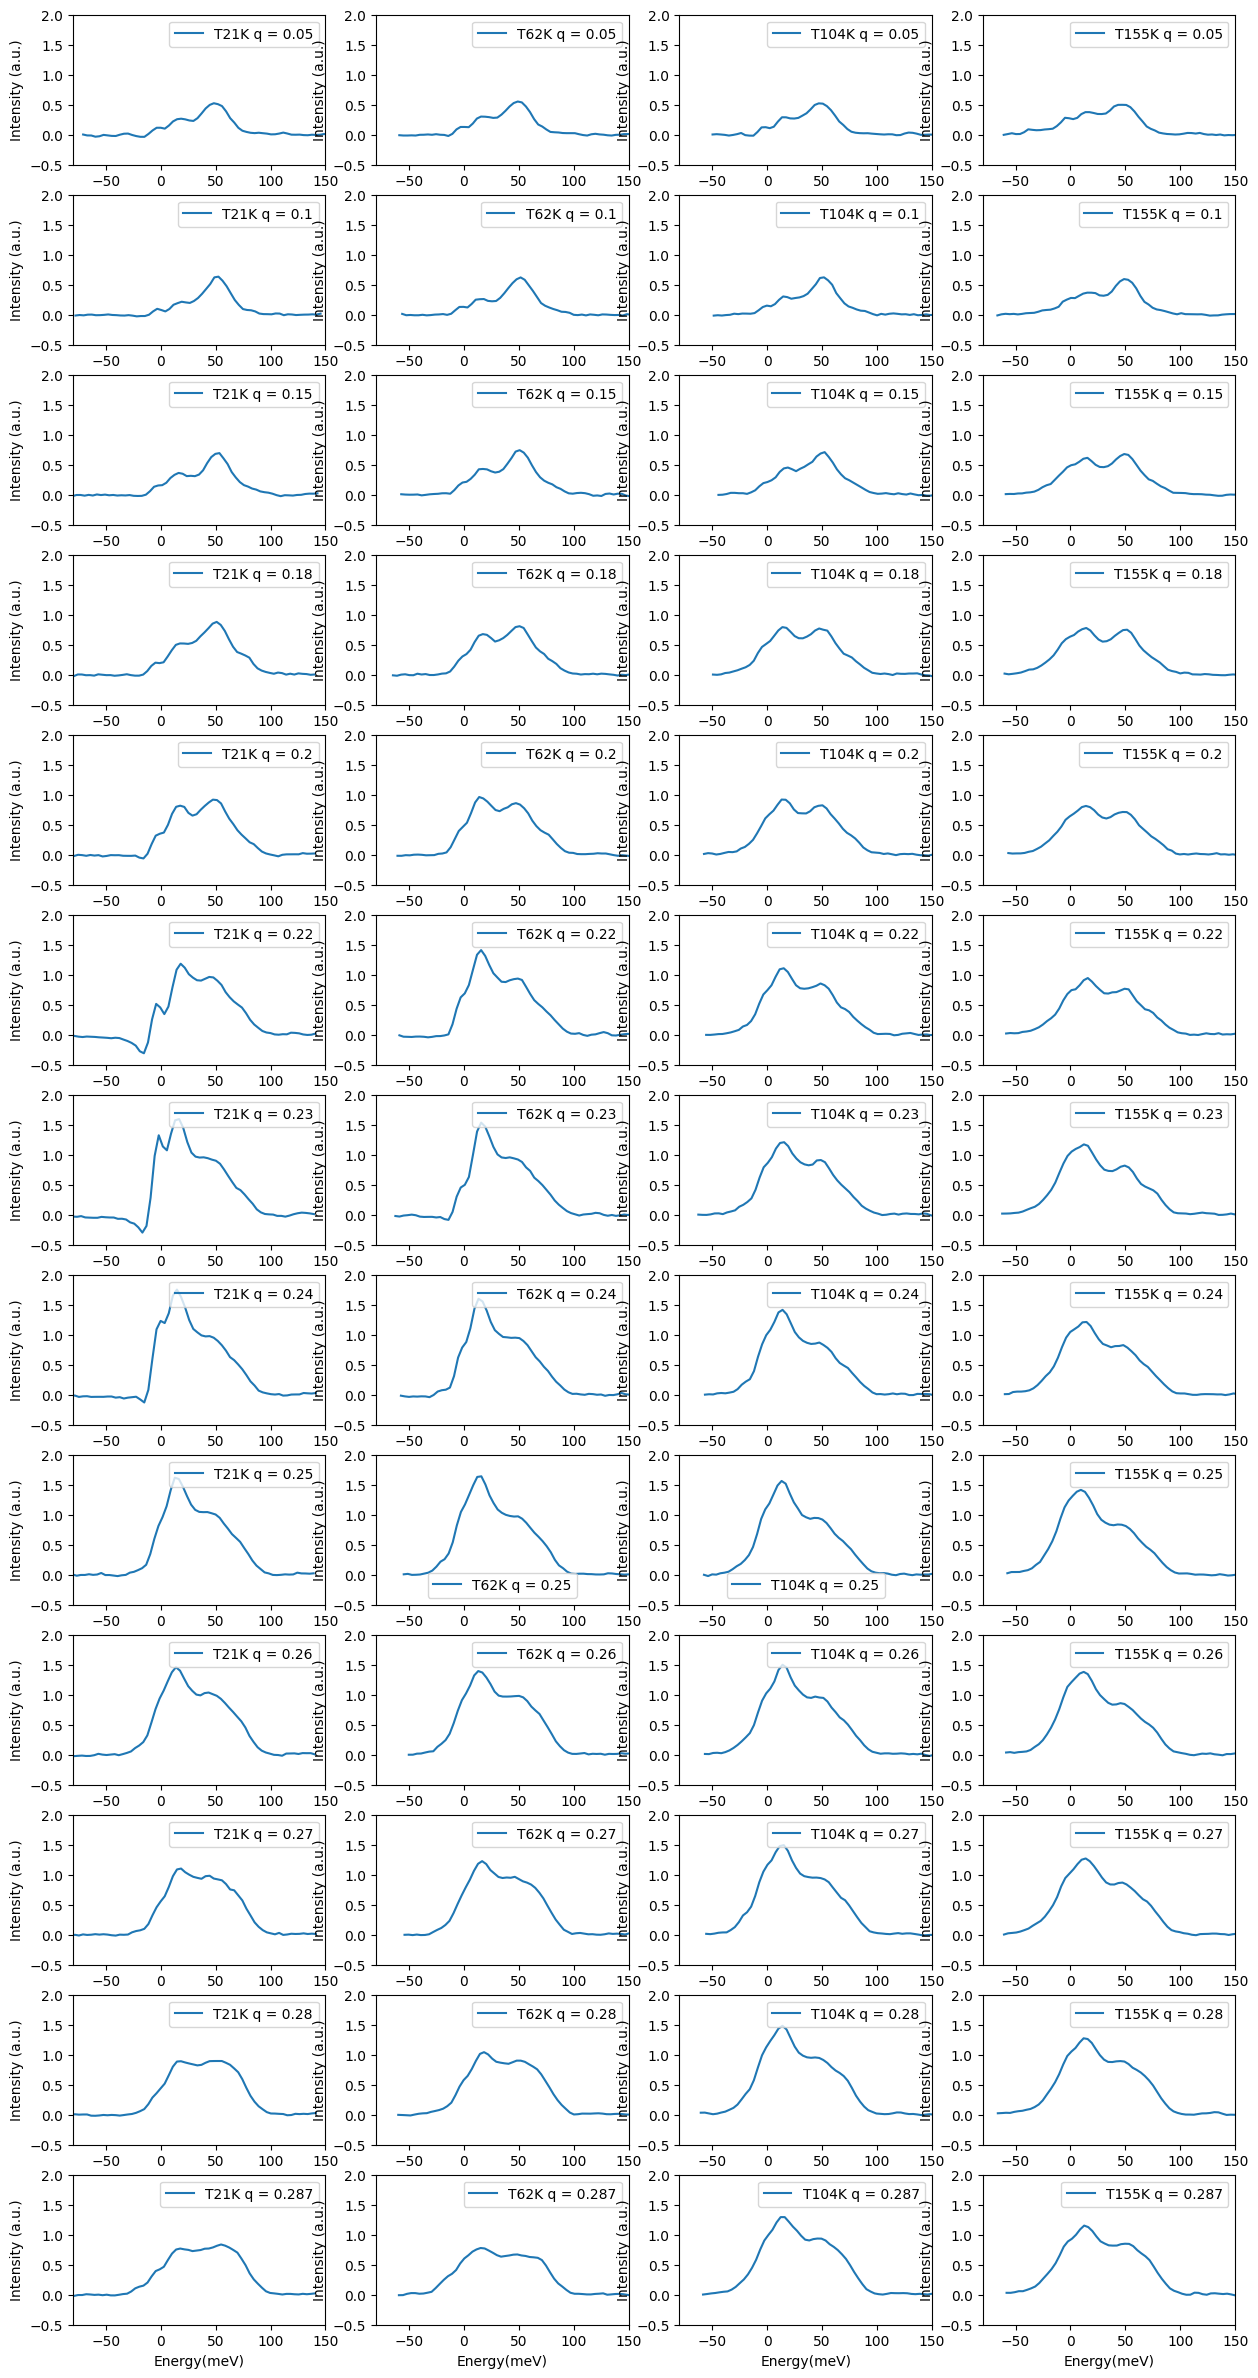

In [ ]:
fig, axs = plt.subplots(13,4,figsize=(15,30))
for i,temperature_char in enumerate(temperature_chars):
    T = exp._temperature_list_meV[i]
    for q_index in range(exp._q_size):
        ax = axs[q_index,i]
        ax.plot(exp.Subtracted_realigned_interesting_data[temperature_char][:,2*q_index],exp.Subtracted_realigned_interesting_data[temperature_char][:,2*q_index+1], label = temperature_char + ' q = ' + str(exp.q_list[q_index]))
        ax.set_ylim(-0.5,2)
        ax.set_xlim(-80,150)
        # ax.set_title(temperature_char)
        ax.set_xlabel('Energy(meV)')
        ax.set_ylabel('Intensity (a.u.)')
        ax.legend()

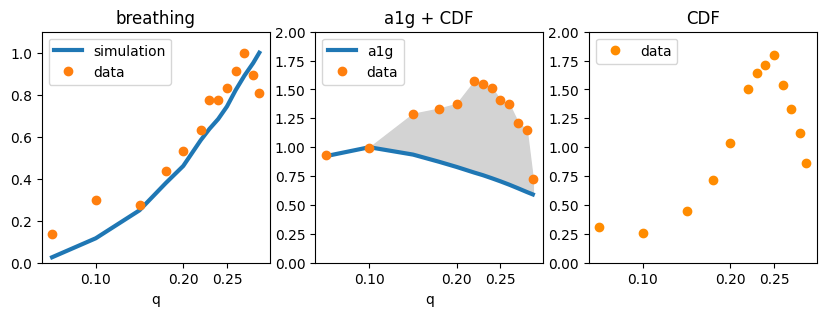

In [ ]:
# extract intensity vs q by picking the maximum intensity at each q
fig,ax = plt.subplots(1,3,figsize=(10,3))
I_br = np.zeros(exp._q_size)
I_ap = np.zeros(exp._q_size)
I_a1g = np.zeros(exp._q_size)
I_br_fitting = np.zeros(exp._q_size)
I_ap_fitting = np.zeros(exp._q_size)
I_a1g_fitting = np.zeros(exp._q_size)
I_cdf_fitting = np.zeros(exp._q_size)
Fitting_result = exp.Fit_results['T62K']['optimized_parameters']


for q_index,q in enumerate(exp.q_list):
    I_br[q_index] = max(Z_simulation_breathing_conv[:,q_index])
    I_ap[q_index] = max(Z_simulation_apical_conv[:,q_index])
    I_a1g[q_index] = max(Z_simulation_a1g_conv[:,q_index])
    I_br_fitting[q_index] = Fitting_result[q_index][12]
    I_ap_fitting[q_index] = Fitting_result[q_index][8]
    I_a1g_fitting[q_index] = Fitting_result[q_index][8]
    I_cdf_fitting[q_index] = Fitting_result[q_index][5]


a1g_factor = 1.57

ax[0].plot(exp.q_list,I_br/max(I_br), label = 'simulation',linewidth=3)
ax[0].plot(exp.q_list,I_br_fitting/max(I_br_fitting),'o', label = 'data')
ax[0].set_xlabel('q'); ax[0].legend(); ax[0].set_title("breathing")
ax[0].set_xticks([0.1,0.2,0.25]); ax[0].set_ylim(0,1.1)


ax[1].plot(exp.q_list,I_a1g/max(I_a1g), label = 'a1g',linewidth=3)
ax[1].plot(exp.q_list,I_a1g_fitting/max(I_a1g_fitting)*a1g_factor, 'o', label = 'data')
ax[1].set_xlabel('q'); ax[1].legend(); ax[1].set_title("a1g + CDF")
ax[1].set_ylim(0,2); ax[1].set_xticks([0.1,0.2,0.25])

ax[2].plot(exp.q_list,I_cdf_fitting/max(I_cdf_fitting)*1.8, 'o',label = 'data', color='darkorange')
ax[2].set_ylim(0,2); ax[2].legend(); ax[2].set_title("CDF"); ax[2].set_xticks([0.1,0.2,0.25])

ax[1].fill_between(exp.q_list,I_a1g_fitting/max(I_a1g_fitting)*a1g_factor,I_a1g/max(I_a1g),color='lightgrey')


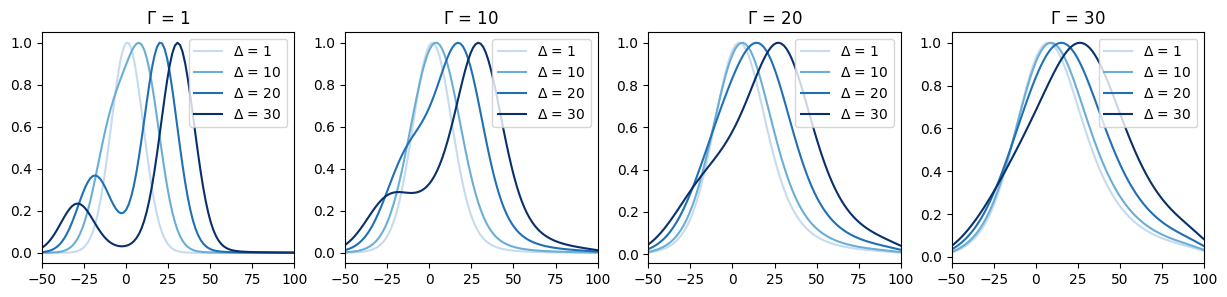

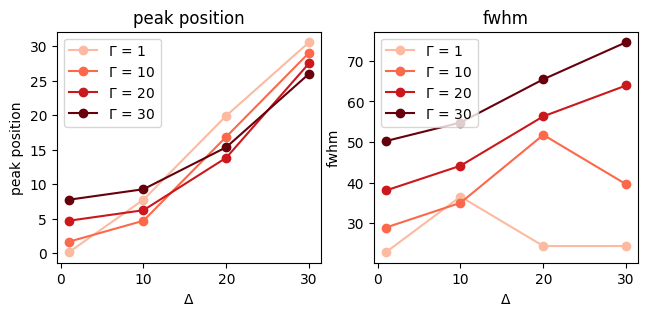

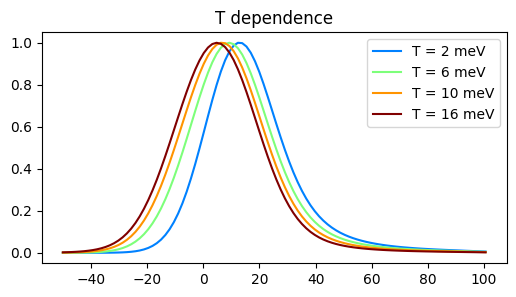

In [ ]:
# visualize the S function
def fun_chi(x,A,Gamma,Delta):
        normalization_factor = 1/2 * 1/np.sqrt(Delta**2)
        chi = 1/(Delta**2 - (x + 1j*(Gamma))**2)
        return np.imag(chi * normalization_factor)*A

def fun_S(x,A,Gamma,Delta,T):
    return 2/(1-np.exp(-x/T))*fun_chi(x,A,Gamma,Delta)

def fun_S_convoluted(x,Gamma,Delta,T):
    x_left = min(x)
    x_right = max(x)
    x_left_shifted = x_left - (x_right + x_left)/2
    x_right_shifted = x_right - (x_right + x_left)/2
    x_gaussian = np.linspace(x_left_shifted,x_right_shifted,len(x))
    res = exp._resolution
    y = fun_S(x,1,Gamma,Delta,T)
    y_conv = convolve(y, mf.fun_gaussian(x_gaussian,0,1,res), mode='same')
    return y_conv/max(y_conv)

def fun_S_convoluted_lorentzian(x,Gamma,Delta,T):
    x_left = min(x)
    x_right = max(x)
    x_left_shifted = x_left - (x_right + x_left)/2
    x_right_shifted = x_right - (x_right + x_left)/2
    x_lorentzian = np.linspace(x_left_shifted,x_right_shifted,len(x))
    res = 16
    y = fun_S(x,1,Gamma,Delta,T)
    y_conv = convolve(y, mf.fun_lorentzian(x_lorentzian,0,1,res), mode='same')
    return y_conv/max(y_conv)



def find_fwhm(x,y):
    epsilon = 0.05
    xs = x[(y>0.5-epsilon)&(y<0.5+epsilon)]
    return xs[-1]-xs[0]

#  plot convoluted S function
fig,ax = plt.subplots(1,4,figsize=(15,3))
x = np.linspace(-50.1,100.6,100)
Gamma_list = [1,10,20,30]
Delta_list = [1,10,20,30]
T = 20
fig2, ax2 = plt.subplots(1,2,figsize=(7.5,3))
fig3, ax3 = plt.subplots(1,1,figsize=(6,3))
peak = np.zeros(4)
fwhm = np.zeros(4)
for i,Gamma in enumerate(Gamma_list):
    for j,Delta in enumerate(Delta_list):
        y = fun_S_convoluted(x,Gamma,Delta,T)
        y = y/max(y)
        # color according to delta 
        ax[i].plot(x,y, label=f"$\Delta$ = {Delta}", color=plt.cm.Blues((j+1)/len(Delta_list)))
        ax[i].set_title(f'$\Gamma$ = {Gamma}')
        ax[i].set_xlim(-50,100)
        peak[j] = x[y == max(y)]
        fwhm[j] = find_fwhm(x,y)
    ax2[0].plot(Delta_list,peak, 'o-', label=f'$\Gamma$ = {Gamma}', color = plt.cm.Reds((i+1)/len(Gamma_list)))
    ax2[1].plot(Delta_list,fwhm, 'o-', label=f'$\Gamma$ = {Gamma}', color = plt.cm.Reds((i+1)/len(Gamma_list)))
    # legend upper right
    ax[i].legend(loc='upper right')
ax2[0].legend()
ax2[0].set_title('peak position'); ax2[0].set_xlabel('$\Delta$'); ax2[0].set_ylabel('peak position')
ax2[1].legend()
ax2[1].set_title('fwhm'); ax2[1].set_xlabel('$\Delta$'); ax2[1].set_ylabel('fwhm')

T_list = [2,6,10,16]
for i,T in enumerate(T_list):
    y = fun_S_convoluted(x,10,10,T)
    y = y/max(y)
    ax3.plot(x,y, label=f"T = {T} meV", color=plt.cm.jet((i+1)/len(T_list)))
ax3.set_title('T dependence')
ax3.legend()


#fig.savefig('S_function_convoluted.jpg',dpi=100)
#fig2.savefig('S_function_peak_fwhm.jpg',dpi=100)

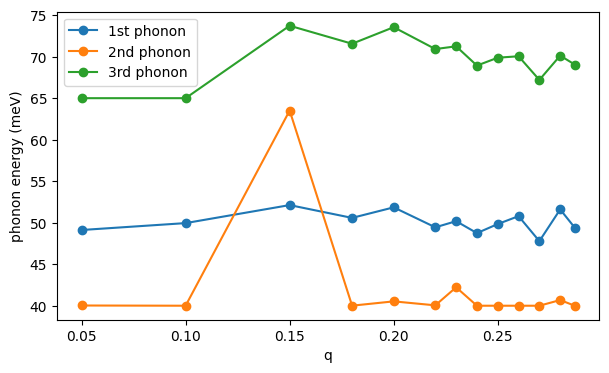

In [ ]:
# plotting the first fitting parameter for each phonons as a function of q at 21K
fig, ax = plt.subplots(1,1,figsize=(7,4))
temperature_char = 'T62K'
phonon1_energy = np.zeros(exp._q_size)
phonon2_energy = np.zeros(exp._q_size)
phonon3_energy = np.zeros(exp._q_size)
for q_index in range(exp._q_size):
    phonon1_energy[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][7]
    phonon2_energy[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][9]
    phonon3_energy[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][11]

ax.plot(exp._q_list, phonon1_energy, '-o', label = '1st phonon')
ax.plot(exp._q_list, phonon2_energy, '-o', label = '2nd phonon')
ax.plot(exp._q_list, phonon3_energy, '-o', label = '3rd phonon')
ax.set_xlabel('q')
ax.set_ylabel('phonon energy (meV)')
ax.legend()


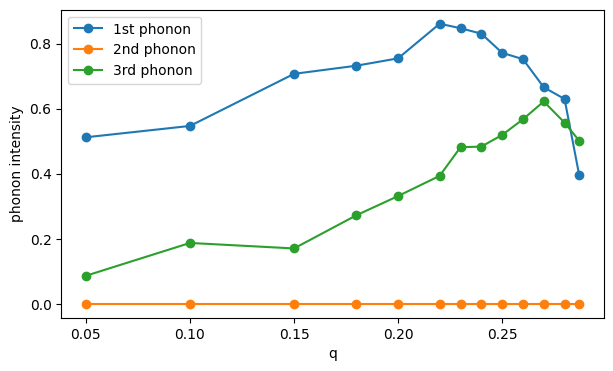

In [ ]:
# plotting the second fitting parameter for each phonons as a function of q at 21K
fig, ax = plt.subplots(1,1,figsize=(7,4))
phonon1_intensity = np.zeros(exp._q_size)
phonon2_intensity = np.zeros(exp._q_size)
phonon3_intensity = np.zeros(exp._q_size)
for q_index in range(exp._q_size):
    phonon1_intensity[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][8]
    phonon2_intensity[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][10]
    phonon3_intensity[q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][12]

ax.plot(exp._q_list, phonon1_intensity, '-o', label = '1st phonon')
ax.plot(exp._q_list, phonon2_intensity, '-o', label = '2nd phonon')
ax.plot(exp._q_list, phonon3_intensity, '-o', label = '3rd phonon')
ax.set_xlabel('q')
ax.set_ylabel('phonon intensity')
ax.legend()


In [ ]:
print(f" FWHM at 155K is {exp.Fit_results['T155K']['optimized_parameters'][8][6]}")
print(f" FWHM at 104K is {exp.Fit_results['T104K']['optimized_parameters'][8][6]}")
print(f" FWHM at 62K is {exp.Fit_results['T62K']['optimized_parameters'][8][6]}")
print(f" FWHM at 21K is {exp.Fit_results['T21K']['optimized_parameters'][8][6]}")

 FWHM at 155K is 44.26245190240425
 FWHM at 104K is 41.08089755206389
 FWHM at 62K is 39.27696339689708
 FWHM at 21K is 34.210639069871576


### remarks
1. from 21K - 104K the FWHM of Lorentzian is the resolution.
2. This means that we can't get the "*original*" FWHM by deconvoluting it with a Gaussian
3. 3-phonon fitting might not work here if we want to extract the $\Delta$ and $\Gamma$ information of the CDF


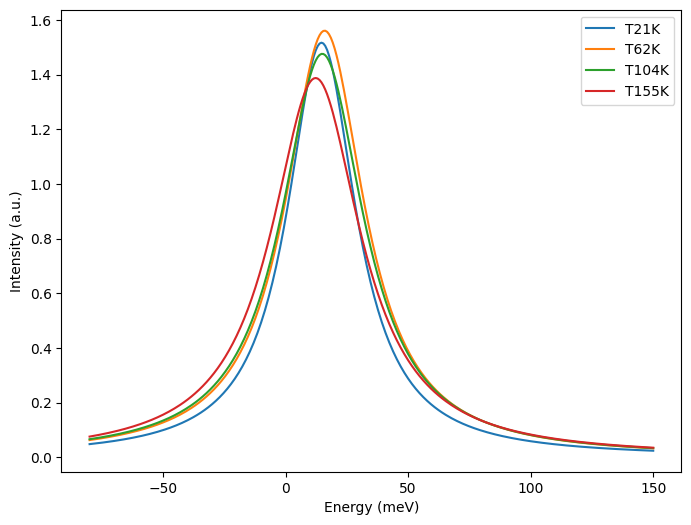

In [ ]:
cdf_index = 8
# plot the CDF ay different temperatures
fig, ax = plt.subplots(1,1,figsize=(8,6))
for i,temperature_char in enumerate(temperature_chars):
    popt = exp.Fit_results[temperature_char]['optimized_parameters'][cdf_index]
    exp.plot_fit_conponent(mf.fun_lorentzian, popt[4:7], ax = ax, fill = False, label = temperature_char, color='C'+str(i))
    
ax.set_xlabel('Energy (meV)')
ax.set_ylabel('Intensity (a.u.)')
ax.legend()

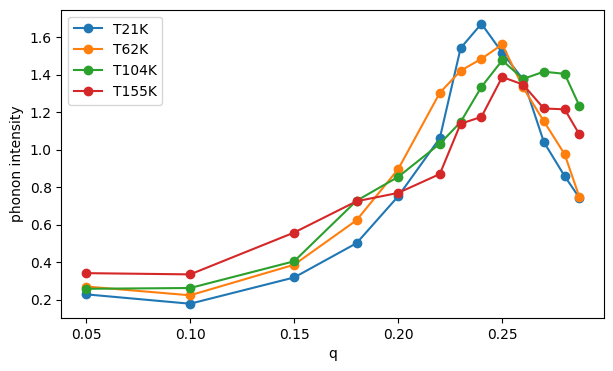

In [ ]:
# plotting the second fitting parameter for each phonons as a function of q at T
fig, ax = plt.subplots(1,1,figsize=(7,4))
CDF_intensity = dict( T21K = np.zeros(exp._q_size), T62K = np.zeros(exp._q_size), T104K = np.zeros(exp._q_size), T155K = np.zeros(exp._q_size))
for temperature_char in exp._temperature_list_string:
    for q_index in range(exp._q_size):
        CDF_intensity[temperature_char][q_index] = exp.Fit_results[temperature_char]['optimized_parameters'][q_index][5]
    ax.plot(exp._q_list, CDF_intensity[temperature_char], '-o', label = temperature_char)
ax.set_xlabel('q')
ax.set_ylabel('phonon intensity')
ax.legend()


34.210639069871576


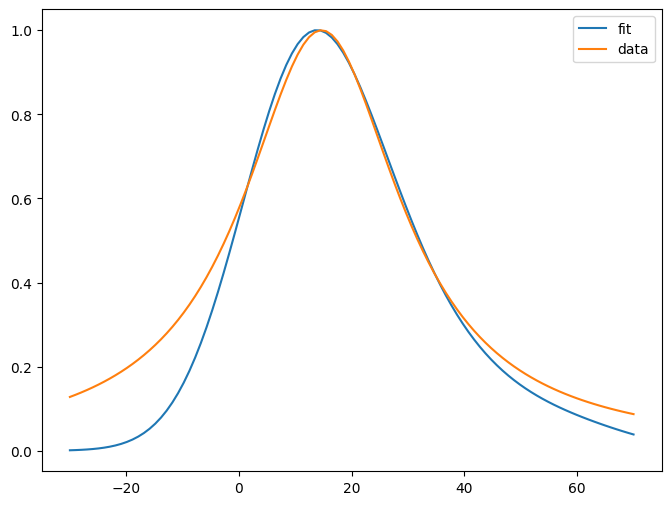

In [ ]:
def fun_chi(x,A,Gamma,Delta):
        normalization_factor = 1/2 * 1/np.sqrt(Delta**2)
        chi = 1/(Delta**2 - (x + 1j*(Gamma))**2)
        return np.imag(chi * normalization_factor)*A

def fun_S(x,A,Gamma,Delta,T):
    return 2/(1-np.exp(-x/T))*fun_chi(x,A,Gamma,Delta)

def fun_S_convoluted(x,Gamma,Delta,T):
    x_left = min(x)
    x_right = max(x)
    x_left_shifted = x_left - (x_right + x_left)/2
    x_right_shifted = x_right - (x_right + x_left)/2
    x_gaussian = np.linspace(x_left_shifted,x_right_shifted,len(x))
    res = exp._resolution
    y = fun_S(x,1,Gamma,Delta,T)
    y_conv = convolve(y, mf.fun_gaussian(x_gaussian,0,1,res), mode='same')
    return y_conv/max(y_conv)
    


# fit CDF with fun_S_convoluted
cdf_index = 8
fig, ax = plt.subplots(1,1,figsize=(8,6))
temperature_char = 'T21K'
temperature = 21*0.086
popt = exp.Fit_results[temperature_char]['optimized_parameters'][cdf_index]
# fit the CDF with fun_S_convoluted
x_data = np.linspace(-30,70,100)
y_data = mf.fun_lorentzian(x_data,*popt[4:7])
print(popt[6])
y_data = y_data/max(y_data)
p0 = [0.2,5,temperature]
epsilon = 0.01
bounds = ([0,0,temperature],[30,30,temperature+epsilon])
sigma = np.ones(len(x_data))
sigma[(x_data>0)&(x_data<30)] = 0.3
popt, pcov = curve_fit(fun_S_convoluted, x_data, y_data, p0 = p0, bounds=bounds,sigma = sigma)


ax.plot(x_data, fun_S_convoluted(x_data,*popt), label = 'fit')
ax.plot(x_data, y_data, label = 'data')
ax.legend()


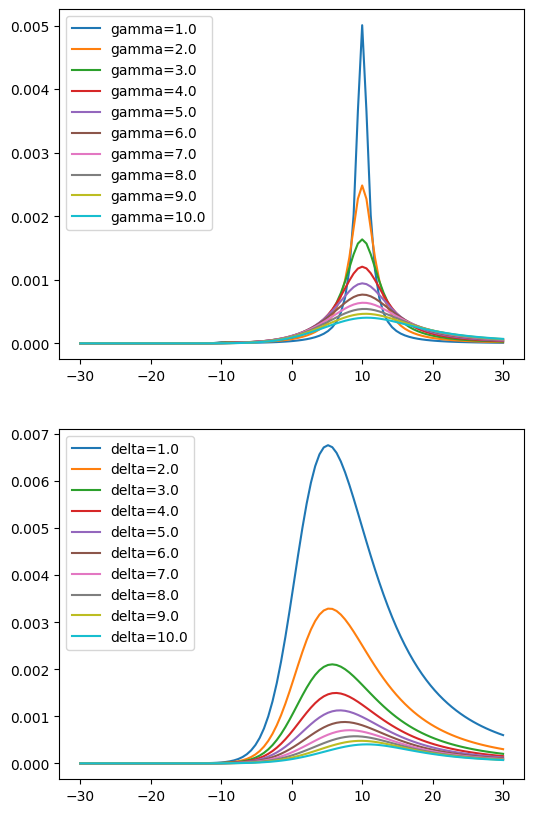

In [ ]:
#plot fun_S with different gamma and delta and with a fixed temperature and A=1
# write a for loop to do it
fig, axs = plt.subplots(2,1,figsize=(6,10))
gamma_list = np.linspace(1,10,10)
delta_list = np.linspace(1,10,10)
temperature = 21*0.086
A=1

for i,gamma in enumerate(gamma_list):
    delta = 10
    ax = axs[0]
    x = np.linspace(-30,30,100)
    y = fun_S(x,A,gamma,delta,temperature)
    ax.plot(x,y,label='gamma='+str(gamma))
    ax.legend()
for i,delta in enumerate(delta_list):
    gamma = 10
    ax = axs[1]
    x = np.linspace(-30,30,100)
    y = fun_S(x,A,gamma,delta,temperature)
    ax.plot(x,y,label='delta='+str(delta))
    ax.legend()







# Problems
1. The FWHM of the CDF is too close to the resolution. Super hard to extract the FWHM before convolution because it's too close to zero. Hard to fit...